# Prédiction de Consommation Énergétique - Campus Aix

## Objectifs du projet

Ce notebook présente un pipeline complet de prédiction de consommation énergétique horaire pour un campus, en utilisant :
- Des données temporelles (heure, jour, mois, année)
- Des variables météorologiques
- Des features dérivées (lags, différences, encodages cycliques)
- Un modèle de réseau de neurones (MLPRegressor)

**Objectif métier** : Prédire la consommation énergétique horaire pour optimiser la gestion des ressources.


## 1. Imports et Configuration

Importation des bibliothèques nécessaires et configuration de la reproductibilité.


In [44]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn - Modèles de base
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

# Modèles de boosting (optionnels)
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost non disponible. Installation : pip install xgboost")

try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠ LightGBM non disponible. Installation : pip install lightgbm")

# Modèles de séries temporelles (optionnels)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("⚠ TensorFlow/Keras non disponible. Installation : pip install tensorflow")

try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("⚠ statsmodels non disponible. Installation : pip install statsmodels")

# Scipy pour distributions (pour RandomSearchCV)
try:
    from scipy.stats import uniform, randint
except ImportError:
    print("⚠ scipy non disponible. Installation : pip install scipy")

# Configuration pour la reproductibilité
np.random.seed(42)

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports effectués avec succès")


⚠ XGBoost non disponible. Installation : pip install xgboost
⚠ LightGBM non disponible. Installation : pip install lightgbm
⚠ TensorFlow/Keras non disponible. Installation : pip install tensorflow
⚠ statsmodels non disponible. Installation : pip install statsmodels
✓ Imports effectués avec succès


## 2. Chargement des Données

Chargement du fichier CSV contenant les données de consommation et les variables explicatives.


In [45]:
# Chargement des données
data = np.genfromtxt('conso_campus_aix.csv', delimiter=',', skip_header=1)

# Extraction de la variable cible (colonne 8 : consommation)
conso = data[:, 8]
y_orig = conso

# Extraction des variables temporelles
Jours_du_mois = data[:, 0].astype(int)
Mois_orig = data[:, 1].astype(int)
Annees_orig = data[:, 2].astype(int)
Heure_orig = data[:, 3].astype(int)

# Variables météorologiques (colonnes 4, 5, 6, 7)
variables_meteo = data[:, [4, 5, 6, 7]]

print(f"✓ Données chargées : {len(data)} observations")
print(f"  - Consommation : min={y_orig.min():.2f}, max={y_orig.max():.2f}, mean={y_orig.mean():.2f}")
print(f"  - Période : {Annees_orig.min()}-{Mois_orig.min():02d} à {Annees_orig.max()}-{Mois_orig.max():02d}")


✓ Données chargées : 8724 observations
  - Consommation : min=44.00, max=304.00, mean=122.50
  - Période : 2021-01 à 2022-12


## 3. Exploration des Données (EDA)

### 3.1. Analyse de la variable cible

Visualisation de la distribution et de l'évolution temporelle de la consommation pour identifier :
- Les tendances et saisonnalités
- Les valeurs aberrantes potentielles
- La distribution des valeurs


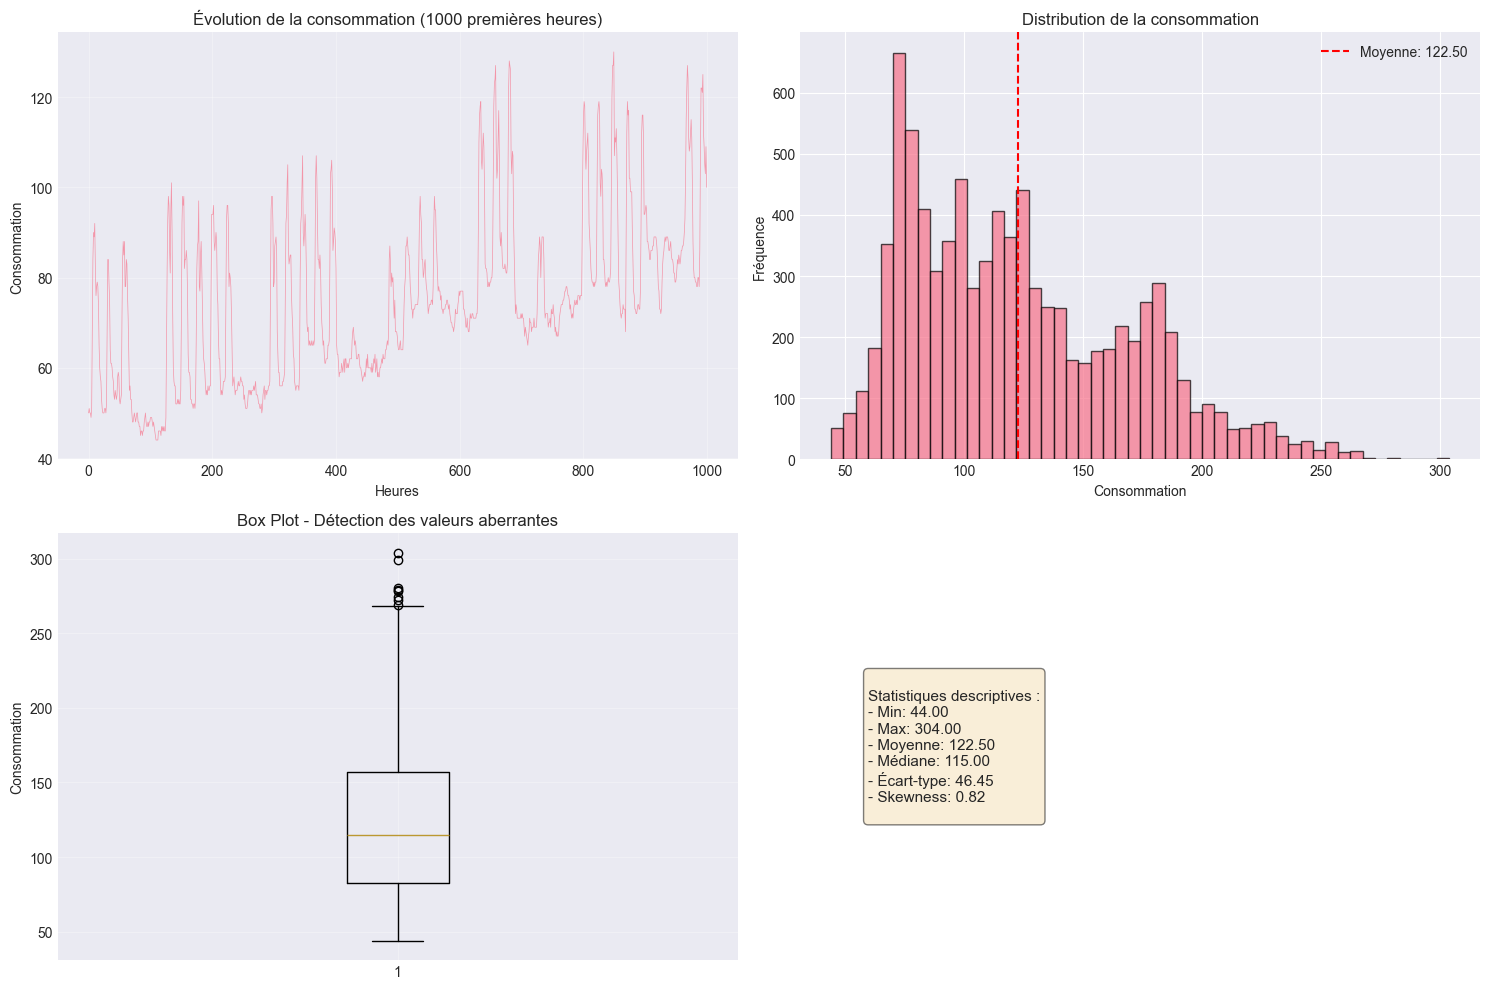

In [46]:
# Visualisation de l'évolution temporelle de la consommation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Série temporelle complète
axes[0, 0].plot(y_orig[:1000], alpha=0.7, linewidth=0.5)
axes[0, 0].set_title('Évolution de la consommation (1000 premières heures)')
axes[0, 0].set_xlabel('Heures')
axes[0, 0].set_ylabel('Consommation')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(y_orig, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution de la consommation')
axes[0, 1].set_xlabel('Consommation')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].axvline(y_orig.mean(), color='r', linestyle='--', label=f'Moyenne: {y_orig.mean():.2f}')
axes[0, 1].legend()

# Box plot pour détecter les outliers
axes[1, 0].boxplot(y_orig, vert=True)
axes[1, 0].set_title('Box Plot - Détection des valeurs aberrantes')
axes[1, 0].set_ylabel('Consommation')
axes[1, 0].grid(True, alpha=0.3)

# Statistiques descriptives
stats_text = f"""
Statistiques descriptives :
- Min: {y_orig.min():.2f}
- Max: {y_orig.max():.2f}
- Moyenne: {y_orig.mean():.2f}
- Médiane: {np.median(y_orig):.2f}
- Écart-type: {y_orig.std():.2f}
- Skewness: {np.abs(y_orig - y_orig.mean()).mean() / y_orig.std():.2f}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


### 3.2. Analyse des patterns temporels

Analyse de la consommation selon l'heure, le jour de la semaine et le mois pour identifier les patterns cycliques.


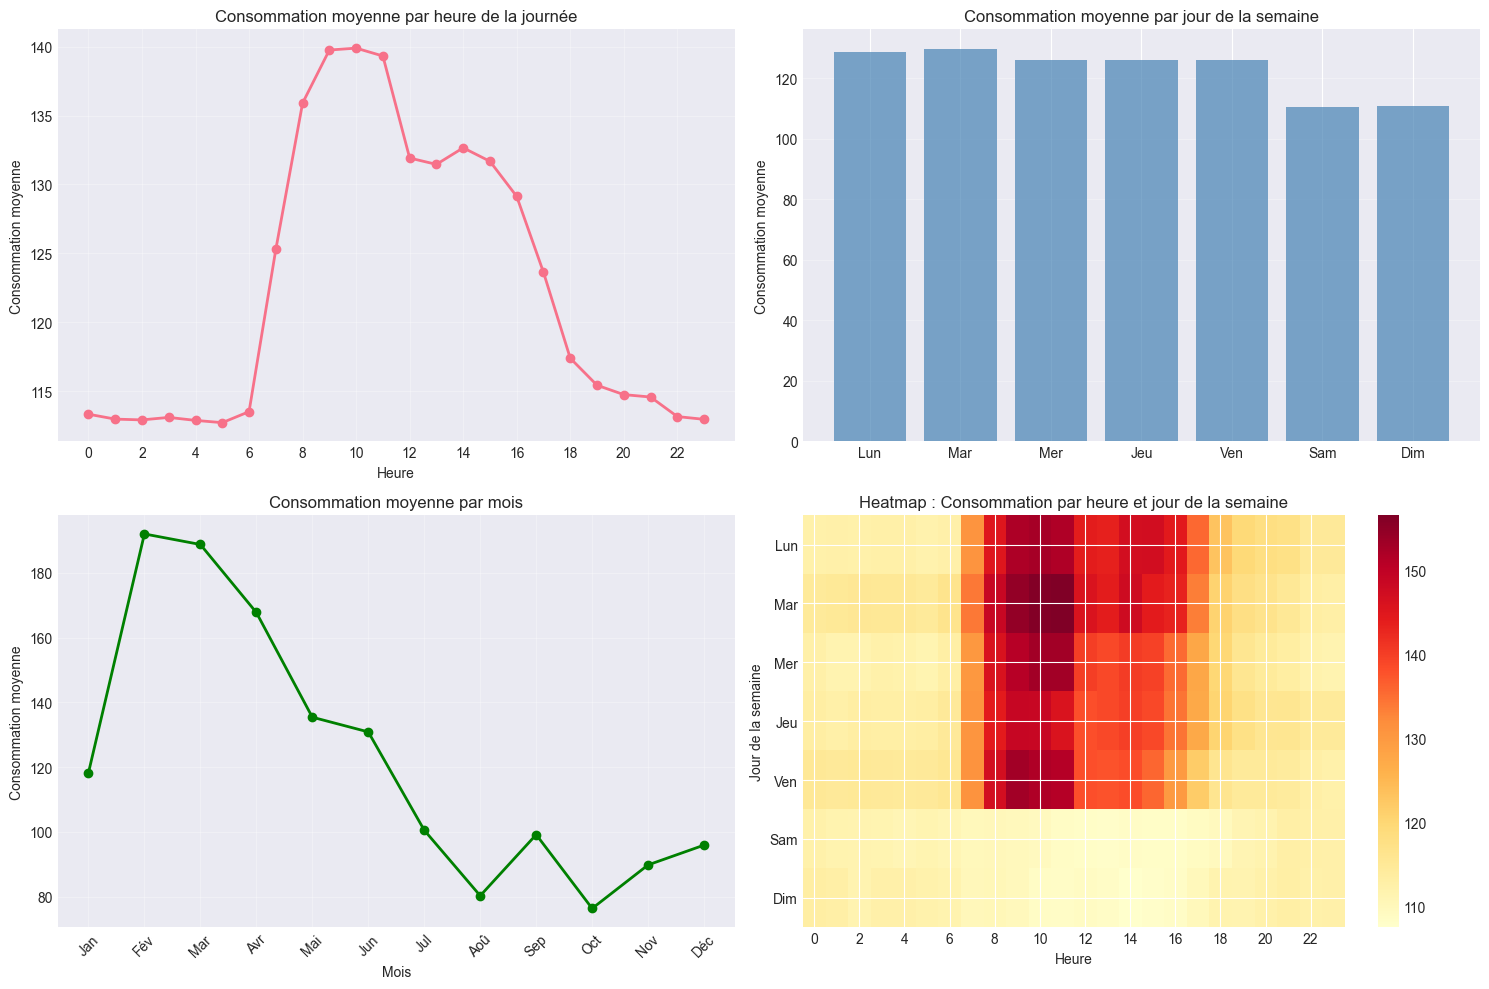

In [47]:
# Calcul des jours de la semaine pour l'analyse
jours_de_la_semaine_temp = []
for annee, mois, jour in zip(Annees_orig, Mois_orig, Jours_du_mois):
    date_obj = datetime.date(annee, mois, jour)
    jours_de_la_semaine_temp.append(date_obj.weekday())
jours_de_la_semaine_temp = np.array(jours_de_la_semaine_temp)

# Visualisation des patterns temporels
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Consommation par heure
conso_par_heure = [y_orig[Heure_orig == h].mean() for h in range(24)]
axes[0, 0].plot(range(24), conso_par_heure, marker='o', linewidth=2, markersize=6)
axes[0, 0].set_title('Consommation moyenne par heure de la journée')
axes[0, 0].set_xlabel('Heure')
axes[0, 0].set_ylabel('Consommation moyenne')
axes[0, 0].set_xticks(range(0, 24, 2))
axes[0, 0].grid(True, alpha=0.3)

# Consommation par jour de la semaine
jours_noms = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
conso_par_jour = [y_orig[jours_de_la_semaine_temp == j].mean() for j in range(7)]
axes[0, 1].bar(jours_noms, conso_par_jour, color='steelblue', alpha=0.7)
axes[0, 1].set_title('Consommation moyenne par jour de la semaine')
axes[0, 1].set_ylabel('Consommation moyenne')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Consommation par mois
conso_par_mois = [y_orig[Mois_orig == m].mean() for m in range(1, 13)]
mois_noms = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
             'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
axes[1, 0].plot(range(1, 13), conso_par_mois, marker='o', linewidth=2, markersize=6, color='green')
axes[1, 0].set_title('Consommation moyenne par mois')
axes[1, 0].set_xlabel('Mois')
axes[1, 0].set_ylabel('Consommation moyenne')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(mois_noms, rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Heatmap consommation par heure et jour de la semaine
heatmap_data = np.zeros((7, 24))
for j in range(7):
    for h in range(24):
        mask = (jours_de_la_semaine_temp == j) & (Heure_orig == h)
        if mask.sum() > 0:
            heatmap_data[j, h] = y_orig[mask].mean()
im = axes[1, 1].imshow(heatmap_data, aspect='auto', cmap='YlOrRd', interpolation='nearest')
axes[1, 1].set_title('Heatmap : Consommation par heure et jour de la semaine')
axes[1, 1].set_xlabel('Heure')
axes[1, 1].set_ylabel('Jour de la semaine')
axes[1, 1].set_yticks(range(7))
axes[1, 1].set_yticklabels(jours_noms)
axes[1, 1].set_xticks(range(0, 24, 2))
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()


### 3.3. Analyse des corrélations et valeurs manquantes

Vérification des corrélations entre variables météorologiques et la consommation, ainsi que détection des valeurs manquantes.


Valeurs manquantes par colonne :
  Colonne 0: Aucune valeur manquante
  Colonne 1: Aucune valeur manquante
  Colonne 2: Aucune valeur manquante
  Colonne 3: Aucune valeur manquante
  Colonne 4: Aucune valeur manquante
  Colonne 5: Aucune valeur manquante
  Colonne 6: Aucune valeur manquante
  Colonne 7: Aucune valeur manquante
  Colonne 8: Aucune valeur manquante


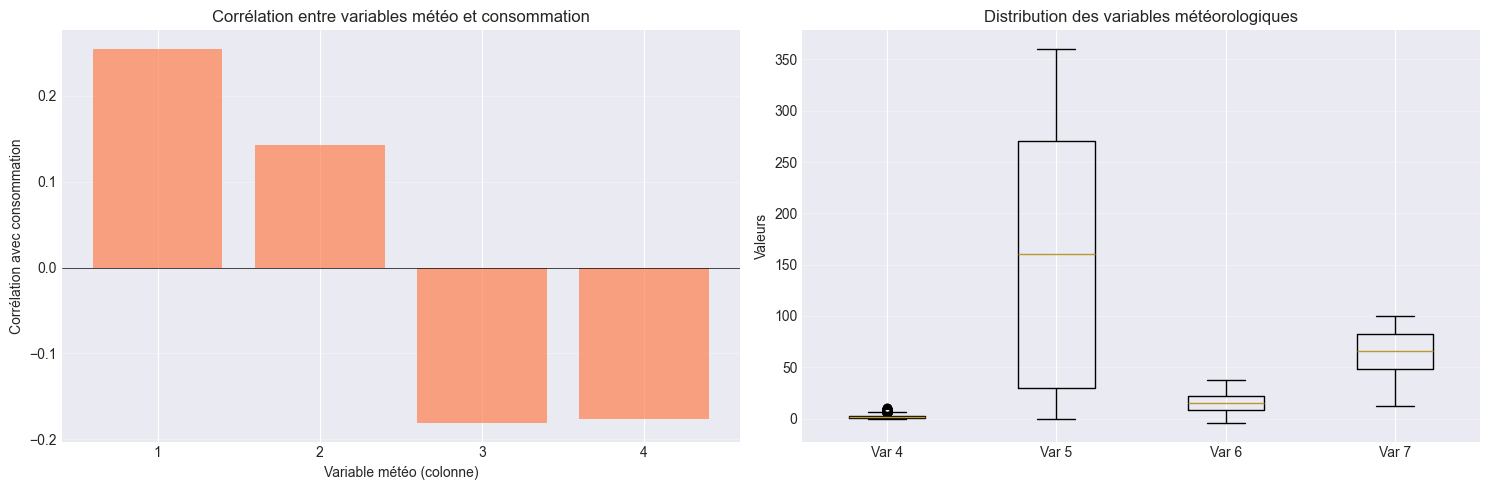


✓ Corrélations variables météo → consommation : ['0.254', '0.143', '-0.181', '-0.176']


In [48]:
# Vérification des valeurs manquantes
missing_data = np.isnan(data).sum(axis=0)
print("Valeurs manquantes par colonne :")
for i, missing in enumerate(missing_data):
    if missing > 0:
        print(f"  Colonne {i}: {missing} valeurs manquantes ({missing/len(data)*100:.2f}%)")
    else:
        print(f"  Colonne {i}: Aucune valeur manquante")

# Analyse des corrélations avec les variables météorologiques
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Corrélations entre variables météorologiques et consommation
corr_with_target = []
for i in range(4):
    corr = np.corrcoef(variables_meteo[:, i], y_orig)[0, 1]
    corr_with_target.append(corr)

axes[0].bar(range(1, 5), corr_with_target, color='coral', alpha=0.7)
axes[0].set_title('Corrélation entre variables météo et consommation')
axes[0].set_xlabel('Variable météo (colonne)')
axes[0].set_ylabel('Corrélation avec consommation')
axes[0].set_xticks(range(1, 5))
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# Distribution des variables météorologiques
axes[1].boxplot([variables_meteo[:, i] for i in range(4)], labels=[f'Var {i+4}' for i in range(4)])
axes[1].set_title('Distribution des variables météorologiques')
axes[1].set_ylabel('Valeurs')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Corrélations variables météo → consommation : {[f'{c:.3f}' for c in corr_with_target]}")


### 📊 Interprétation & Pistes d'amélioration - EDA

**Observations clés :**
- Distribution de la consommation : identifier si elle est normale, asymétrique, ou présente des outliers
- Patterns temporels : heures de pointe, différences week-end/semaine, saisonnalité
- Corrélations météo : quelles variables météorologiques sont les plus prédictives

**Pistes d'amélioration :**
- Appliquer une transformation (log, Box-Cox) si la distribution est asymétrique
- Créer des features d'interaction entre variables météo et variables temporelles
- Gérer les outliers si nécessaire (capping, suppression, ou modélisation séparée)


## 4. Feature Engineering Complet - Phases par Phases

Ce chapitre présente un feature engineering complet et structuré en plusieurs phases pour maximiser la performance du modèle.

### Phase 1 : Encodages cycliques

Les variables temporelles (heure, mois, jour de la semaine) sont cycliques. L'encodage sinusoïdal permet au modèle de comprendre cette cyclicité (ex: 23h est proche de 0h).


In [49]:
# Encodage cyclique de l'heure (24h)
H_sin = np.sin(2 * np.pi * Heure_orig / 24)
H_cos = np.cos(2 * np.pi * Heure_orig / 24)

# Encodage cyclique du mois (12 mois)
M_sin = np.sin(2 * np.pi * Mois_orig / 12)
M_cos = np.cos(2 * np.pi * Mois_orig / 12)

# Calcul du jour de la semaine
jours_de_la_semaine = []
for annee, mois, jour in zip(Annees_orig, Mois_orig, Jours_du_mois):
    date_obj = datetime.date(annee, mois, jour)
    jours_de_la_semaine.append(date_obj.weekday())
jours_de_la_semaine = np.array(jours_de_la_semaine)

# Encodage cyclique du jour de la semaine (7 jours)
S_sin = np.sin(2 * np.pi * jours_de_la_semaine / 7)
S_cos = np.cos(2 * np.pi * jours_de_la_semaine / 7)

print("✓ Encodages cycliques créés")
print(f"  - Heure: sin/cos (24h cycle)")
print(f"  - Mois: sin/cos (12 mois cycle)")
print(f"  - Jour semaine: sin/cos (7 jours cycle)")


✓ Encodages cycliques créés
  - Heure: sin/cos (24h cycle)
  - Mois: sin/cos (12 mois cycle)
  - Jour semaine: sin/cos (7 jours cycle)


### Phase 1.2 : Visualisation des encodages cycliques

Visualisation pour vérifier que les encodages capturent bien la cyclicité des variables temporelles.


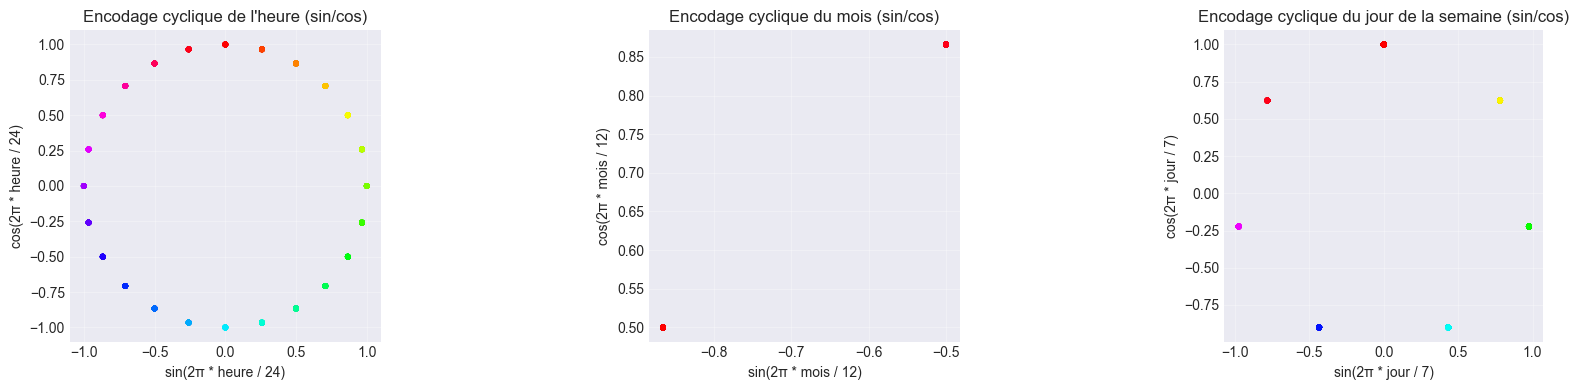

In [50]:
# Visualisation des encodages cycliques
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Encodage heure
axes[0].scatter(H_sin[:1000], H_cos[:1000], c=Heure_orig[:1000], cmap='hsv', alpha=0.6, s=10)
axes[0].set_title('Encodage cyclique de l\'heure (sin/cos)')
axes[0].set_xlabel('sin(2π * heure / 24)')
axes[0].set_ylabel('cos(2π * heure / 24)')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Encodage mois
axes[1].scatter(M_sin[:1000], M_cos[:1000], c=Mois_orig[:1000], cmap='hsv', alpha=0.6, s=10)
axes[1].set_title('Encodage cyclique du mois (sin/cos)')
axes[1].set_xlabel('sin(2π * mois / 12)')
axes[1].set_ylabel('cos(2π * mois / 12)')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

# Encodage jour de la semaine
axes[2].scatter(S_sin[:1000], S_cos[:1000], c=jours_de_la_semaine[:1000], cmap='hsv', alpha=0.6, s=10)
axes[2].set_title('Encodage cyclique du jour de la semaine (sin/cos)')
axes[2].set_xlabel('sin(2π * jour / 7)')
axes[2].set_ylabel('cos(2π * jour / 7)')
axes[2].grid(True, alpha=0.3)
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()


### Phase 2 : Variables binaires et catégorielles

Création de variables binaires pour capturer des effets spécifiques (week-end, heures actives, périodes de pointe).


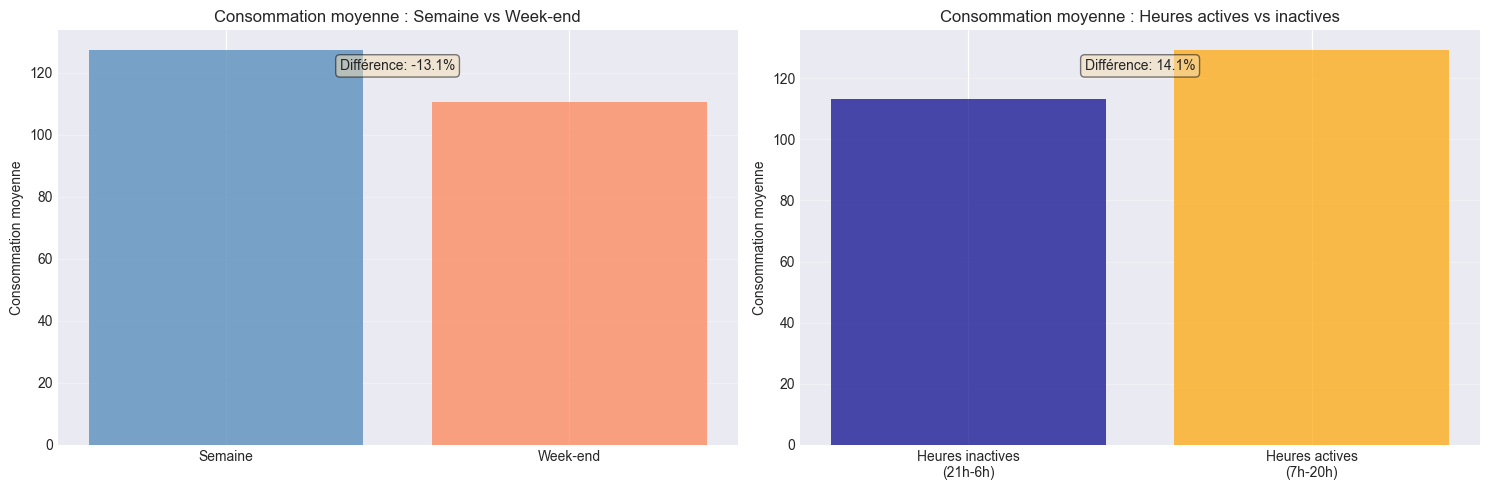

✓ Variables binaires créées
  - Week-end: 2489 observations (28.5%)
  - Heures actives: 5084 observations (58.3%)
  - Heures de pointe: 2181 observations (25.0%)
  - Nuit: 3276 observations (37.6%)
  - Jour ouvrable: 6235 observations (71.5%)


In [51]:
# Variable binaire Week-end (1 si samedi ou dimanche, 0 sinon)
is_weekend = (jours_de_la_semaine >= 5).astype(int)

# Variable binaire Heures actives (1 si entre 7h et 20h, 0 sinon)
# Cette variable aide le modèle à mieux caler le "talon" de consommation nocturne
is_active_hours = ((Heure_orig >= 7) & (Heure_orig <= 20)).astype(int)

# Variable binaire Heures de pointe (1 si entre 8h-10h ou 18h-20h, 0 sinon)
# Périodes de forte consommation typiques
is_peak_hours = (((Heure_orig >= 8) & (Heure_orig <= 10)) | 
                 ((Heure_orig >= 18) & (Heure_orig <= 20))).astype(int)

# Variable binaire Nuit (1 si entre 22h et 6h, 0 sinon)
is_night = ((Heure_orig >= 22) | (Heure_orig <= 6)).astype(int)

# Variable binaire Jour ouvrable (1 si lundi-vendredi, 0 sinon)
is_weekday = (jours_de_la_semaine < 5).astype(int)

# Visualisation de l'impact de ces variables
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Impact du week-end
conso_weekend = y_orig[is_weekend == 1].mean()
conso_semaine = y_orig[is_weekend == 0].mean()
axes[0].bar(['Semaine', 'Week-end'], [conso_semaine, conso_weekend], 
            color=['steelblue', 'coral'], alpha=0.7)
axes[0].set_title('Consommation moyenne : Semaine vs Week-end')
axes[0].set_ylabel('Consommation moyenne')
axes[0].grid(True, alpha=0.3, axis='y')
diff_pct = ((conso_weekend - conso_semaine) / conso_semaine) * 100
axes[0].text(0.5, max(conso_semaine, conso_weekend) * 0.95, 
             f'Différence: {diff_pct:.1f}%', ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Impact des heures actives
conso_active = y_orig[is_active_hours == 1].mean()
conso_inactive = y_orig[is_active_hours == 0].mean()
axes[1].bar(['Heures inactives\n(21h-6h)', 'Heures actives\n(7h-20h)'], 
            [conso_inactive, conso_active], color=['darkblue', 'orange'], alpha=0.7)
axes[1].set_title('Consommation moyenne : Heures actives vs inactives')
axes[1].set_ylabel('Consommation moyenne')
axes[1].grid(True, alpha=0.3, axis='y')
diff_pct2 = ((conso_active - conso_inactive) / conso_inactive) * 100
axes[1].text(0.5, max(conso_active, conso_inactive) * 0.95, 
             f'Différence: {diff_pct2:.1f}%', ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"✓ Variables binaires créées")
print(f"  - Week-end: {is_weekend.sum()} observations ({is_weekend.sum()/len(is_weekend)*100:.1f}%)")
print(f"  - Heures actives: {is_active_hours.sum()} observations ({is_active_hours.sum()/len(is_active_hours)*100:.1f}%)")
print(f"  - Heures de pointe: {is_peak_hours.sum()} observations ({is_peak_hours.sum()/len(is_peak_hours)*100:.1f}%)")
print(f"  - Nuit: {is_night.sum()} observations ({is_night.sum()/len(is_night)*100:.1f}%)")
print(f"  - Jour ouvrable: {is_weekday.sum()} observations ({is_weekday.sum()/len(is_weekday)*100:.1f}%)")


### Phase 3 : Features temporelles avancées (Lags et différences)

Les lags (valeurs passées) et les différences capturent l'inertie et les tendances de la consommation. On ajoute des lags supplémentaires pour capturer différents cycles temporels.


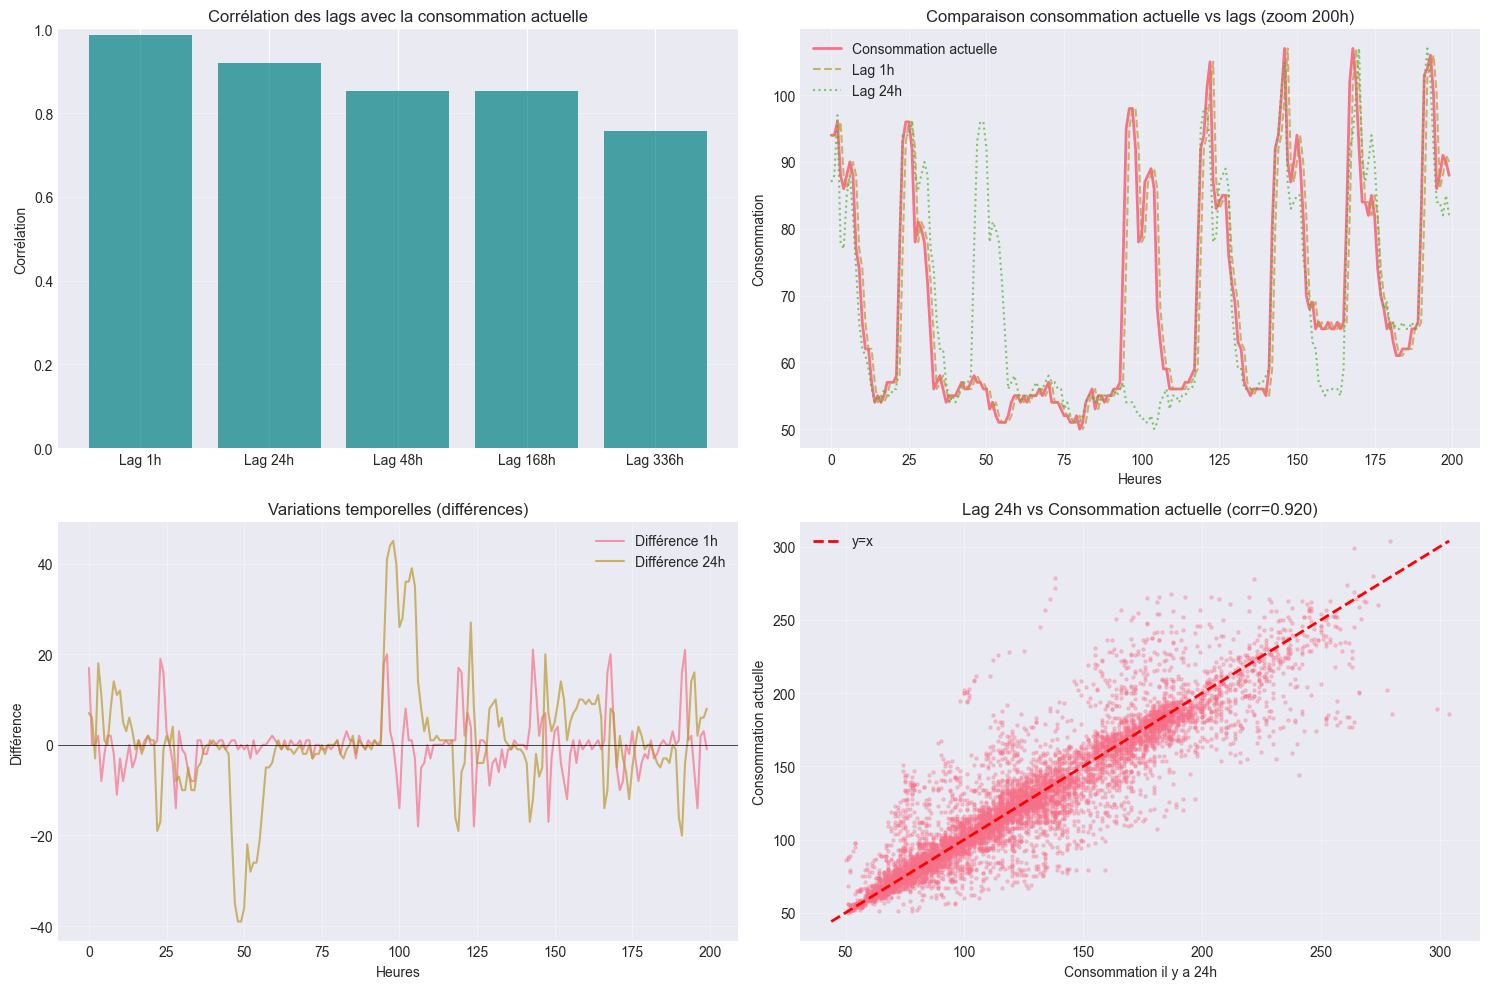

✓ Features temporelles créées
  - Lags: 1h, 2h, 3h, 24h, 48h, 168h, 336h
  - Différences: 1h, 2h, 24h, 48h, 1 semaine


In [52]:
# Création des lags (valeurs passées) - Phase 3.1
lag_1 = np.roll(y_orig, 1)    # Consommation 1h avant
lag_2 = np.roll(y_orig, 2)    # Consommation 2h avant
lag_3 = np.roll(y_orig, 3)    # Consommation 3h avant
lag_24 = np.roll(y_orig, 24)  # Consommation 24h avant (même heure hier)
lag_48 = np.roll(y_orig, 48)  # Consommation 48h avant (même heure avant-hier)
lag_168 = np.roll(y_orig, 168) # Consommation 168h avant (même heure la semaine dernière)
lag_336 = np.roll(y_orig, 336) # Consommation 336h avant (même heure il y a 2 semaines)

# Création des différences (tendances) - Phase 3.2
diff_1h = lag_1 - lag_2        # Variation sur 1h
diff_2h = lag_1 - lag_3        # Variation sur 2h
diff_24h = lag_1 - lag_24      # Variation sur 24h
diff_48h = lag_1 - lag_48      # Variation sur 48h
diff_week = lag_1 - lag_168     # Variation sur 1 semaine

# Visualisation de l'importance des lags
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Corrélation avec la cible
lags = [lag_1, lag_24, lag_48, lag_168, lag_336]
lag_names = ['Lag 1h', 'Lag 24h', 'Lag 48h', 'Lag 168h', 'Lag 336h']
correlations = [np.corrcoef(y_orig, lag)[0, 1] for lag in lags]

axes[0, 0].bar(lag_names, correlations, color='teal', alpha=0.7)
axes[0, 0].set_title('Corrélation des lags avec la consommation actuelle')
axes[0, 0].set_ylabel('Corrélation')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Visualisation des lags sur un extrait
sample_idx = slice(200, 400)
axes[0, 1].plot(y_orig[sample_idx], label='Consommation actuelle', linewidth=2)
axes[0, 1].plot(lag_1[sample_idx], label='Lag 1h', alpha=0.7, linestyle='--')
axes[0, 1].plot(lag_24[sample_idx], label='Lag 24h', alpha=0.7, linestyle=':')
axes[0, 1].set_title('Comparaison consommation actuelle vs lags (zoom 200h)')
axes[0, 1].set_xlabel('Heures')
axes[0, 1].set_ylabel('Consommation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Visualisation des différences
axes[1, 0].plot(diff_1h[sample_idx], label='Différence 1h', alpha=0.7, linewidth=1.5)
axes[1, 0].plot(diff_24h[sample_idx], label='Différence 24h', alpha=0.7, linewidth=1.5)
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_title('Variations temporelles (différences)')
axes[1, 0].set_xlabel('Heures')
axes[1, 0].set_ylabel('Différence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot lag_24 vs consommation (très corrélé)
axes[1, 1].scatter(lag_24[168:], y_orig[168:], alpha=0.3, s=5)
axes[1, 1].plot([y_orig.min(), y_orig.max()], [y_orig.min(), y_orig.max()], 
                'r--', lw=2, label='y=x')
axes[1, 1].set_title(f'Lag 24h vs Consommation actuelle (corr={correlations[1]:.3f})')
axes[1, 1].set_xlabel('Consommation il y a 24h')
axes[1, 1].set_ylabel('Consommation actuelle')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Features temporelles créées")
print(f"  - Lags: 1h, 2h, 3h, 24h, 48h, 168h, 336h")
print(f"  - Différences: 1h, 2h, 24h, 48h, 1 semaine")


### Phase 4 : Moyennes mobiles (Rolling Statistics)

Les moyennes mobiles permettent de lisser les variations et de capturer les tendances à court et moyen terme. Elles sont très utiles pour réduire le bruit dans les données temporelles.


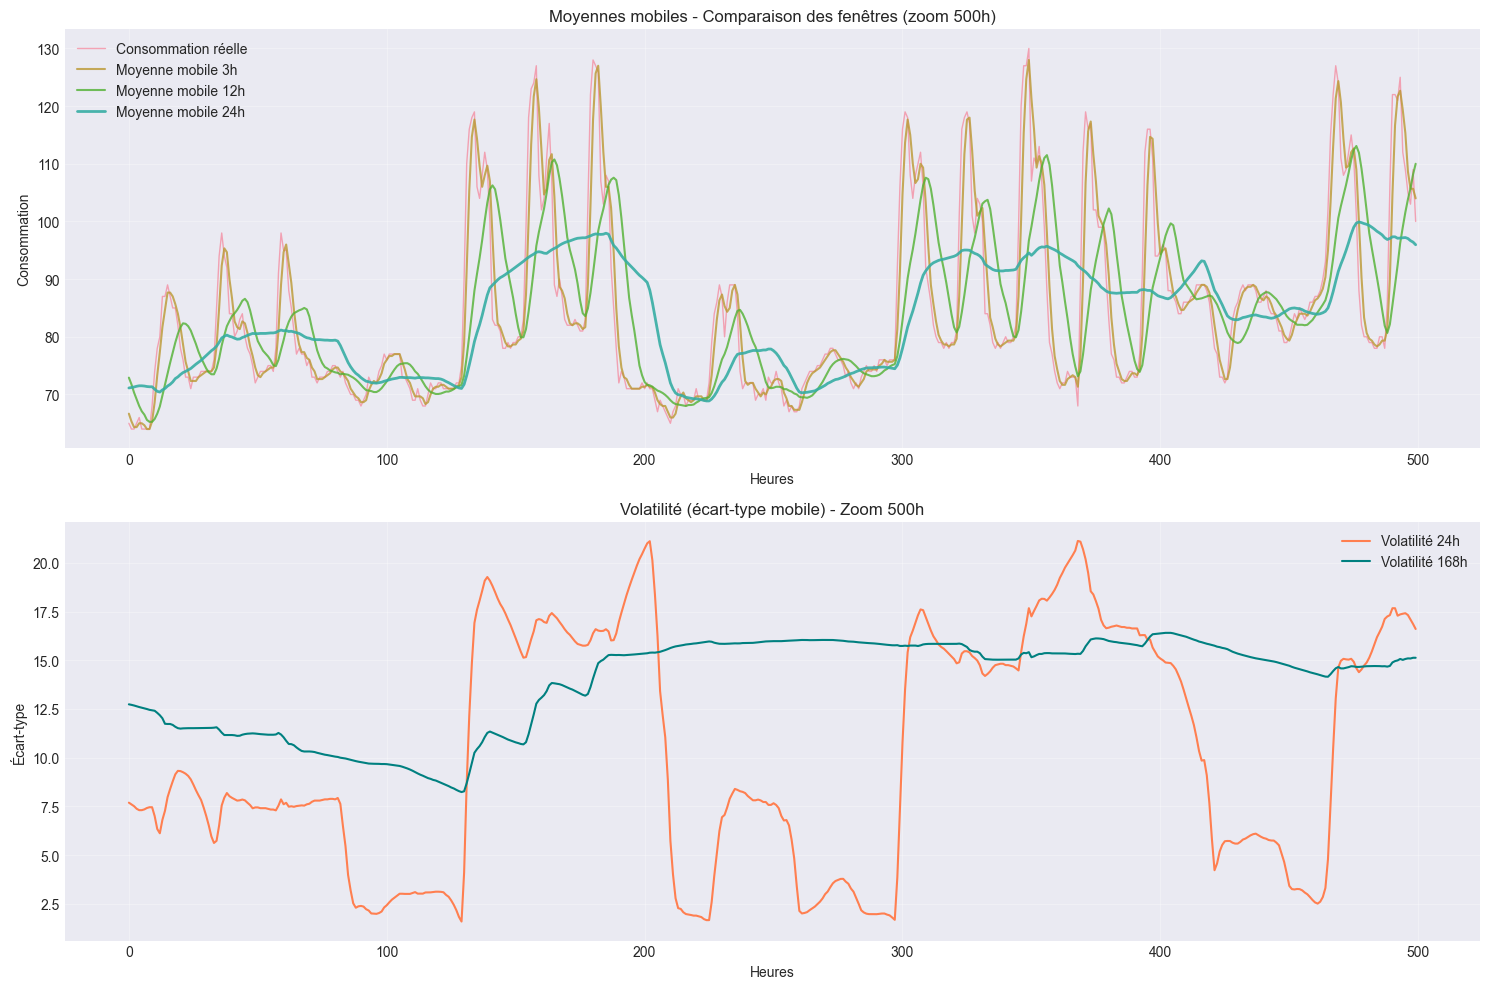

✓ Moyennes mobiles créées
  - Moyennes: 3h, 6h, 12h, 24h, 168h
  - Volatilité: 24h, 168h


In [53]:
# Moyennes mobiles sur différentes fenêtres temporelles
def rolling_mean(data, window):
    """Calcule la moyenne mobile avec une fenêtre donnée"""
    result = np.zeros_like(data)
    for i in range(len(data)):
        start_idx = max(0, i - window + 1)
        result[i] = np.mean(data[start_idx:i+1])
    return result

def rolling_std(data, window):
    """Calcule l'écart-type mobile avec une fenêtre donnée"""
    result = np.zeros_like(data)
    for i in range(len(data)):
        start_idx = max(0, i - window + 1)
        result[i] = np.std(data[start_idx:i+1]) if (i - start_idx + 1) > 1 else 0
    return result

# Moyennes mobiles sur différentes fenêtres
rolling_mean_3h = rolling_mean(y_orig, 3)    # Moyenne sur 3 heures
rolling_mean_6h = rolling_mean(y_orig, 6)    # Moyenne sur 6 heures
rolling_mean_12h = rolling_mean(y_orig, 12)  # Moyenne sur 12 heures
rolling_mean_24h = rolling_mean(y_orig, 24)  # Moyenne sur 24 heures (1 jour)
rolling_mean_168h = rolling_mean(y_orig, 168) # Moyenne sur 168 heures (1 semaine)

# Écart-type mobile (volatilité)
rolling_std_24h = rolling_std(y_orig, 24)     # Volatilité sur 24h
rolling_std_168h = rolling_std(y_orig, 168)   # Volatilité sur 1 semaine

# Visualisation des moyennes mobiles
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Zoom sur 500 heures pour la visualisation
sample_idx = slice(500, 1000)

axes[0].plot(y_orig[sample_idx], label='Consommation réelle', alpha=0.6, linewidth=1)
axes[0].plot(rolling_mean_3h[sample_idx], label='Moyenne mobile 3h', linewidth=1.5, alpha=0.8)
axes[0].plot(rolling_mean_12h[sample_idx], label='Moyenne mobile 12h', linewidth=1.5, alpha=0.8)
axes[0].plot(rolling_mean_24h[sample_idx], label='Moyenne mobile 24h', linewidth=2, alpha=0.9)
axes[0].set_title('Moyennes mobiles - Comparaison des fenêtres (zoom 500h)')
axes[0].set_xlabel('Heures')
axes[0].set_ylabel('Consommation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatilité (écart-type mobile)
axes[1].plot(rolling_std_24h[sample_idx], label='Volatilité 24h', linewidth=1.5, color='coral')
axes[1].plot(rolling_std_168h[sample_idx], label='Volatilité 168h', linewidth=1.5, color='teal')
axes[1].set_title('Volatilité (écart-type mobile) - Zoom 500h')
axes[1].set_xlabel('Heures')
axes[1].set_ylabel('Écart-type')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Moyennes mobiles créées")
print(f"  - Moyennes: 3h, 6h, 12h, 24h, 168h")
print(f"  - Volatilité: 24h, 168h")


### Phase 5 : Features de tendance et accélération

Les features de tendance capturent la direction et l'accélération des changements de consommation, ce qui aide le modèle à anticiper les variations futures.


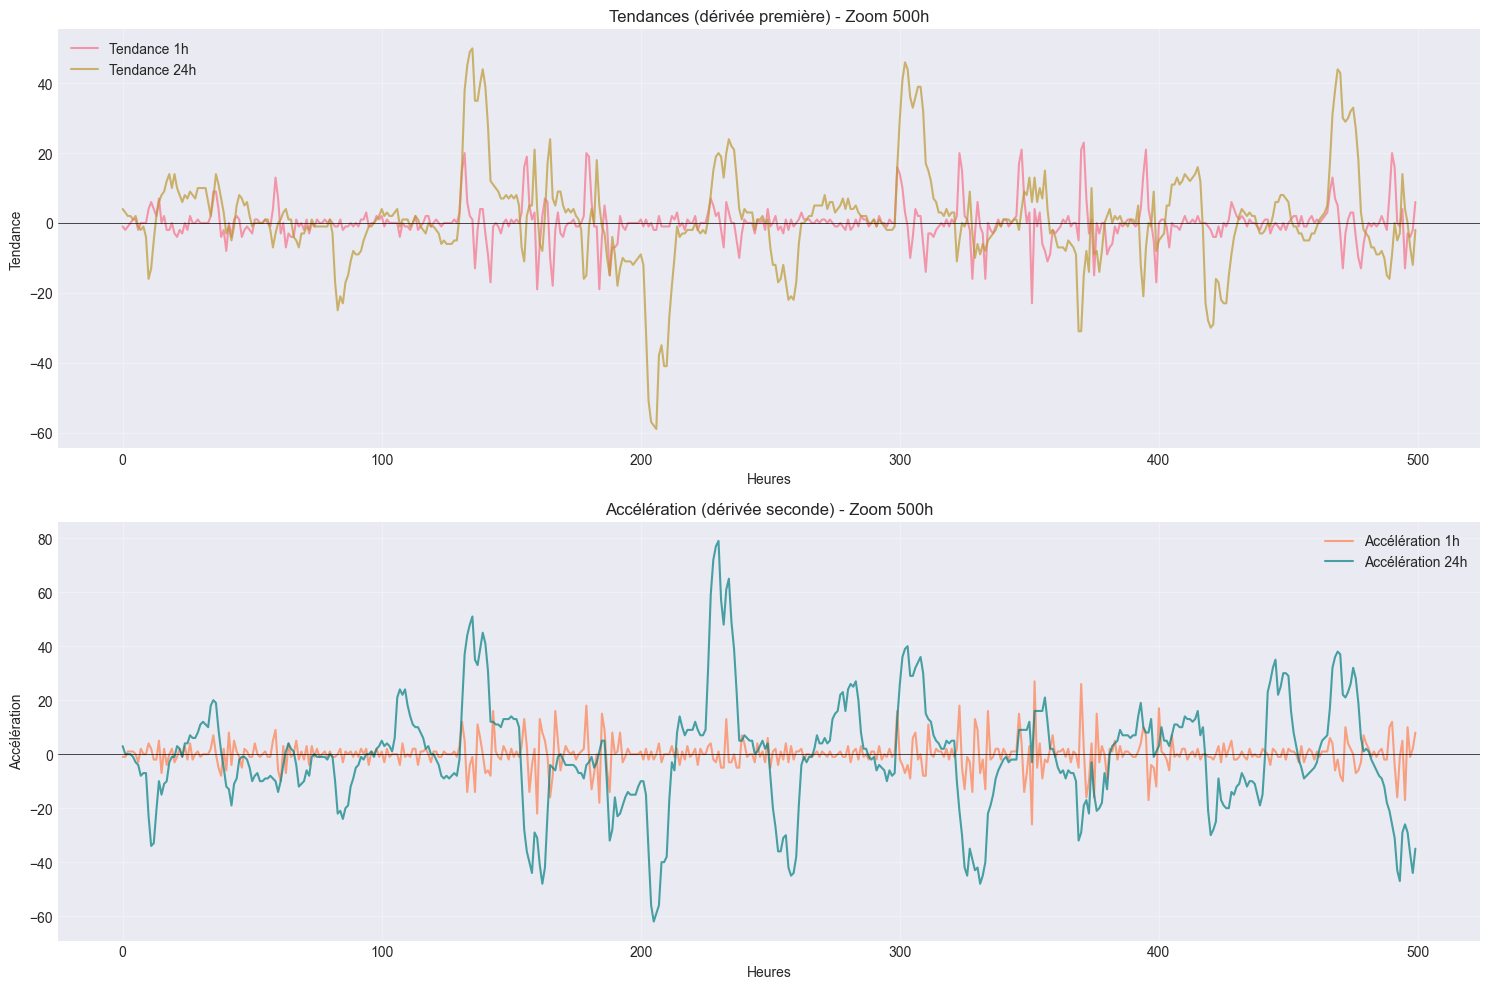

✓ Features de tendance créées
  - Tendances: 1h, 24h
  - Accélérations: 1h, 24h
  - Ratios de variation: 1h, 24h
  - Tendances relatives: 1h, 24h


In [54]:
# Tendance (dérivée première) : vitesse de changement
trend_1h = diff_1h  # Tendance sur 1h (déjà calculée)
trend_24h = diff_24h  # Tendance sur 24h (déjà calculée)

# Accélération (dérivée seconde) : changement de la vitesse
# Accélération = changement de la tendance
acceleration_1h = diff_1h - np.roll(diff_1h, 1)  # Accélération sur 1h
acceleration_24h = diff_24h - np.roll(diff_24h, 24)  # Accélération sur 24h

# Ratio de variation (pourcentage de changement)
ratio_change_1h = diff_1h / (lag_2 + 1e-6)  # Éviter division par zéro
ratio_change_24h = diff_24h / (lag_24 + 1e-6)

# Tendance relative (normalisée par la valeur moyenne)
trend_relative_1h = diff_1h / (rolling_mean_24h + 1e-6)
trend_relative_24h = diff_24h / (rolling_mean_24h + 1e-6)

# Visualisation des features de tendance
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

sample_idx = slice(500, 1000)

# Tendance et accélération
axes[0].plot(trend_1h[sample_idx], label='Tendance 1h', alpha=0.7, linewidth=1.5)
axes[0].plot(trend_24h[sample_idx], label='Tendance 24h', alpha=0.7, linewidth=1.5)
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_title('Tendances (dérivée première) - Zoom 500h')
axes[0].set_xlabel('Heures')
axes[0].set_ylabel('Tendance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(acceleration_1h[sample_idx], label='Accélération 1h', alpha=0.7, linewidth=1.5, color='coral')
axes[1].plot(acceleration_24h[sample_idx], label='Accélération 24h', alpha=0.7, linewidth=1.5, color='teal')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('Accélération (dérivée seconde) - Zoom 500h')
axes[1].set_xlabel('Heures')
axes[1].set_ylabel('Accélération')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Features de tendance créées")
print(f"  - Tendances: 1h, 24h")
print(f"  - Accélérations: 1h, 24h")
print(f"  - Ratios de variation: 1h, 24h")
print(f"  - Tendances relatives: 1h, 24h")


### Phase 6 : Features d'interaction

Les features d'interaction capturent les effets combinés de plusieurs variables. Par exemple, la consommation peut varier différemment selon que c'est un week-end ou un jour de semaine, ou selon la saison et la météo.


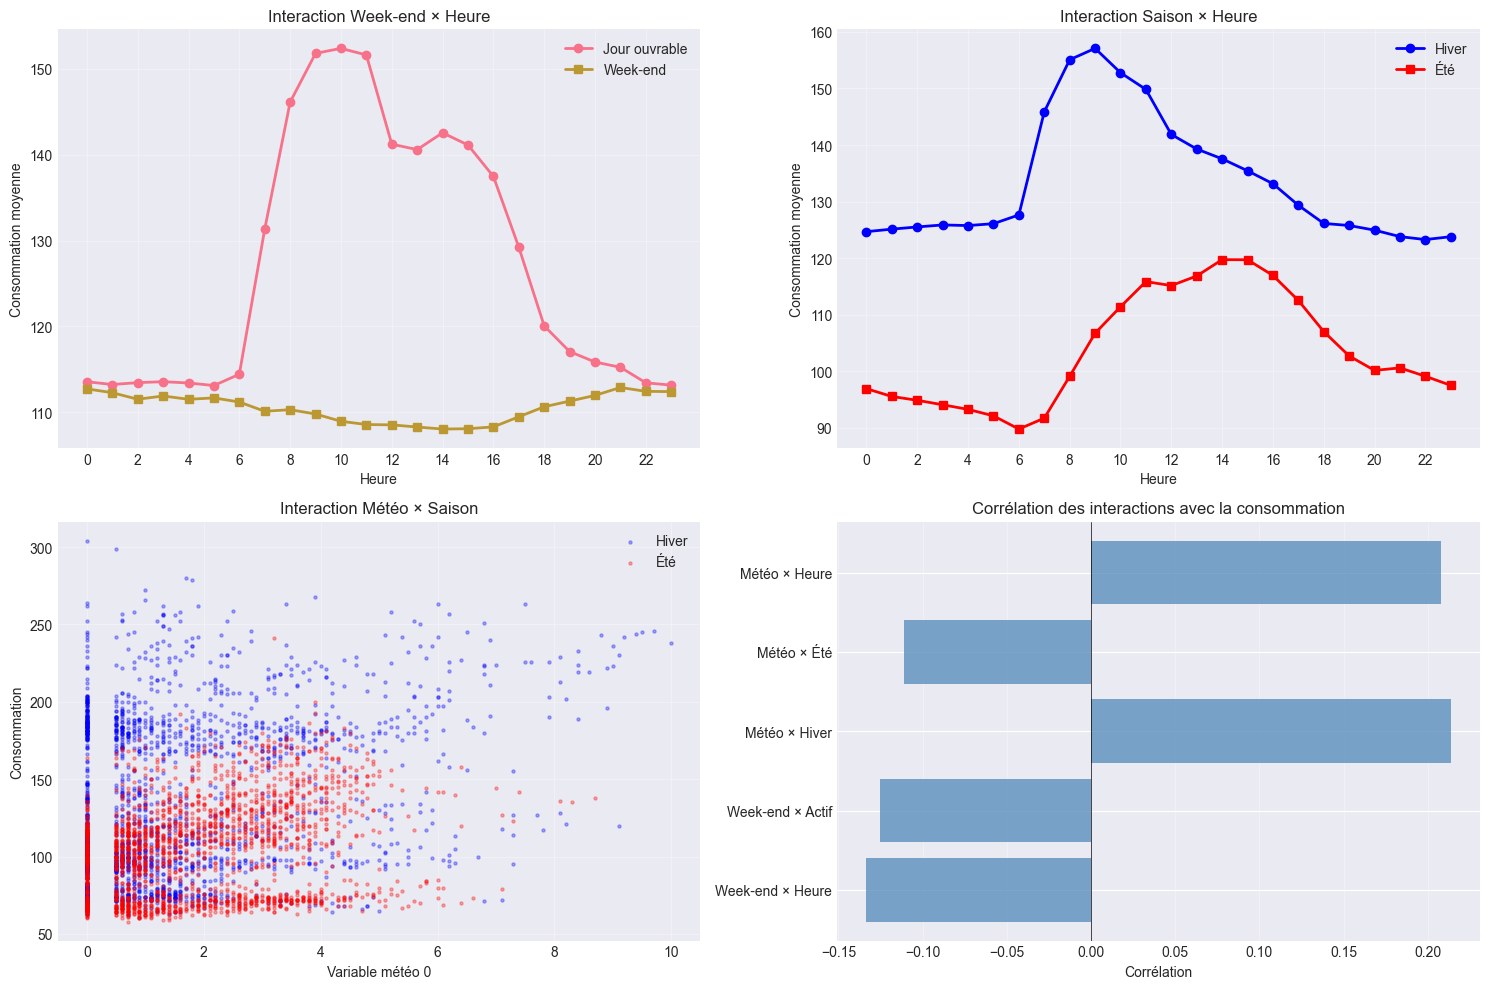

✓ Features d'interaction créées
  - Interactions temporelles: week-end × heure, week-end × actif, etc.
  - Interactions saisonnières: saison × heure, saison × météo
  - Interactions météo: météo × heure, météo × saison


In [55]:
# Interactions temporelles
# Week-end × Heure (consommation différente le week-end selon l'heure)
weekend_x_hour = is_weekend * Heure_orig
weekend_x_active = is_weekend * is_active_hours
weekend_x_peak = is_weekend * is_peak_hours

# Saison × Heure (consommation différente selon la saison et l'heure)
# On définit les saisons : Hiver (12,1,2), Printemps (3,4,5), Été (6,7,8), Automne (9,10,11)
is_winter = ((Mois_orig == 12) | (Mois_orig <= 2)).astype(int)
is_spring = ((Mois_orig >= 3) & (Mois_orig <= 5)).astype(int)
is_summer = ((Mois_orig >= 6) & (Mois_orig <= 8)).astype(int)
is_fall = ((Mois_orig >= 9) & (Mois_orig <= 11)).astype(int)

season_x_hour_winter = is_winter * Heure_orig
season_x_hour_summer = is_summer * Heure_orig

# Interactions météo × temps
# On utilise les variables météorologiques (colonnes 4, 5, 6, 7)
meteo_var_0 = variables_meteo[:, 0]  # Première variable météo
meteo_var_1 = variables_meteo[:, 1]    # Deuxième variable météo
meteo_var_2 = variables_meteo[:, 2]    # Troisième variable météo
meteo_var_3 = variables_meteo[:, 3]    # Quatrième variable météo

# Météo × Saison (l'impact de la météo peut varier selon la saison)
meteo0_x_season_winter = meteo_var_0 * is_winter
meteo0_x_season_summer = meteo_var_0 * is_summer

# Météo × Heure (l'impact de la météo peut varier selon l'heure)
meteo0_x_hour = meteo_var_0 * Heure_orig
meteo1_x_hour = meteo_var_1 * Heure_orig

# Interactions temporelles complexes
# Week-end × Mois (consommation différente le week-end selon le mois)
weekend_x_month = is_weekend * Mois_orig

# Heure active × Mois
active_x_month = is_active_hours * Mois_orig

# Visualisation de quelques interactions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Impact week-end × heure
conso_weekend_by_hour = []
conso_weekday_by_hour = []
for h in range(24):
    mask_we = (is_weekend == 1) & (Heure_orig == h)
    mask_wd = (is_weekend == 0) & (Heure_orig == h)
    if mask_we.sum() > 0 and mask_wd.sum() > 0:
        conso_weekend_by_hour.append(y_orig[mask_we].mean())
        conso_weekday_by_hour.append(y_orig[mask_wd].mean())
    else:
        conso_weekend_by_hour.append(0)
        conso_weekday_by_hour.append(0)

axes[0, 0].plot(range(24), conso_weekday_by_hour, label='Jour ouvrable', marker='o', linewidth=2)
axes[0, 0].plot(range(24), conso_weekend_by_hour, label='Week-end', marker='s', linewidth=2)
axes[0, 0].set_title('Interaction Week-end × Heure')
axes[0, 0].set_xlabel('Heure')
axes[0, 0].set_ylabel('Consommation moyenne')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# Impact saison × heure (hiver vs été)
conso_winter_by_hour = []
conso_summer_by_hour = []
for h in range(24):
    mask_w = (is_winter == 1) & (Heure_orig == h)
    mask_s = (is_summer == 1) & (Heure_orig == h)
    if mask_w.sum() > 0 and mask_s.sum() > 0:
        conso_winter_by_hour.append(y_orig[mask_w].mean())
        conso_summer_by_hour.append(y_orig[mask_s].mean())
    else:
        conso_winter_by_hour.append(0)
        conso_summer_by_hour.append(0)

axes[0, 1].plot(range(24), conso_winter_by_hour, label='Hiver', marker='o', linewidth=2, color='blue')
axes[0, 1].plot(range(24), conso_summer_by_hour, label='Été', marker='s', linewidth=2, color='red')
axes[0, 1].set_title('Interaction Saison × Heure')
axes[0, 1].set_xlabel('Heure')
axes[0, 1].set_ylabel('Consommation moyenne')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 2))

# Distribution des interactions météo × saison
axes[1, 0].scatter(meteo_var_0[is_winter == 1], y_orig[is_winter == 1], 
                   alpha=0.3, s=5, label='Hiver', color='blue')
axes[1, 0].scatter(meteo_var_0[is_summer == 1], y_orig[is_summer == 1], 
                   alpha=0.3, s=5, label='Été', color='red')
axes[1, 0].set_title('Interaction Météo × Saison')
axes[1, 0].set_xlabel('Variable météo 0')
axes[1, 0].set_ylabel('Consommation')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Corrélation des interactions avec la cible
interactions = [
    ('Week-end × Heure', weekend_x_hour),
    ('Week-end × Actif', weekend_x_active),
    ('Météo × Hiver', meteo0_x_season_winter),
    ('Météo × Été', meteo0_x_season_summer),
    ('Météo × Heure', meteo0_x_hour)
]
interaction_corrs = [np.corrcoef(y_orig, inter)[0, 1] for _, inter in interactions]
interaction_names = [name for name, _ in interactions]

axes[1, 1].barh(interaction_names, interaction_corrs, color='steelblue', alpha=0.7)
axes[1, 1].set_title('Corrélation des interactions avec la consommation')
axes[1, 1].set_xlabel('Corrélation')
axes[1, 1].grid(True, alpha=0.3, axis='x')
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print(f"✓ Features d'interaction créées")
print(f"  - Interactions temporelles: week-end × heure, week-end × actif, etc.")
print(f"  - Interactions saisonnières: saison × heure, saison × météo")
print(f"  - Interactions météo: météo × heure, météo × saison")


### Phase 7 : Transformations des variables météorologiques

Les variables météorologiques peuvent avoir des relations non-linéaires avec la consommation. On applique des transformations pour mieux capturer ces relations.


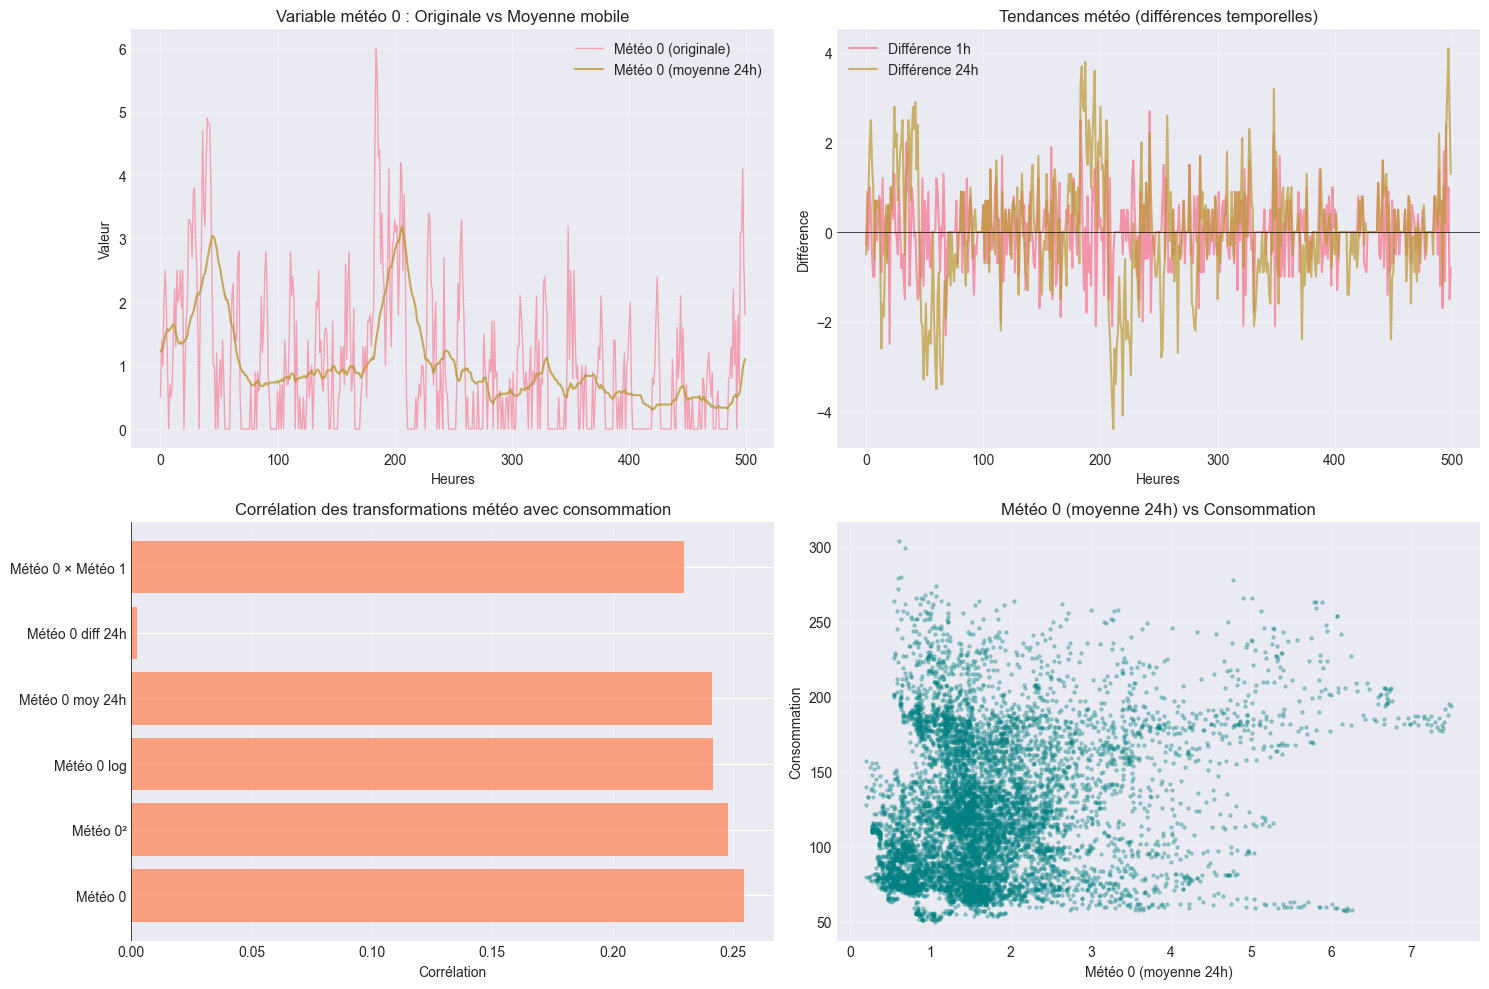

✓ Transformations météorologiques créées
  - Transformations: log, carré, cube
  - Moyennes mobiles: 6h, 24h
  - Différences temporelles: 1h, 24h
  - Interactions météo: produits, ratios


In [56]:
# Transformations logarithmiques (pour variables avec distribution asymétrique)
meteo0_log = np.log1p(meteo_var_0 - meteo_var_0.min() + 1)  # log1p pour éviter log(0)
meteo1_log = np.log1p(meteo_var_1 - meteo_var_1.min() + 1)
meteo2_log = np.log1p(meteo_var_2 - meteo_var_2.min() + 1)
meteo3_log = np.log1p(meteo_var_3 - meteo_var_3.min() + 1)

# Transformations polynomiales (carré, cube) pour capturer les non-linéarités
meteo0_squared = meteo_var_0 ** 2
meteo1_squared = meteo_var_1 ** 2
meteo0_cubed = meteo_var_0 ** 3

# Moyennes mobiles des variables météo (lissage)
meteo0_rolling_6h = rolling_mean(meteo_var_0, 6)
meteo0_rolling_24h = rolling_mean(meteo_var_0, 24)
meteo1_rolling_24h = rolling_mean(meteo_var_1, 24)

# Différences temporelles des variables météo (tendances météo)
meteo0_diff_1h = meteo_var_0 - np.roll(meteo_var_0, 1)
meteo0_diff_24h = meteo_var_0 - np.roll(meteo_var_0, 24)
meteo1_diff_24h = meteo_var_1 - np.roll(meteo_var_1, 24)

# Interactions entre variables météo (produits)
meteo0_x_meteo1 = meteo_var_0 * meteo_var_1
meteo0_x_meteo2 = meteo_var_0 * meteo_var_2
meteo1_x_meteo2 = meteo_var_1 * meteo_var_2

# Ratios entre variables météo
meteo_ratio_0_1 = meteo_var_0 / (meteo_var_1 + 1e-6)  # Éviter division par zéro
meteo_ratio_0_2 = meteo_var_0 / (meteo_var_2 + 1e-6)

# Visualisation des transformations météo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sample_idx = slice(500, 1000)

# Variables météo originales vs transformées
axes[0, 0].plot(meteo_var_0[sample_idx], label='Météo 0 (originale)', alpha=0.6, linewidth=1)
axes[0, 0].plot(meteo0_rolling_24h[sample_idx], label='Météo 0 (moyenne 24h)', linewidth=1.5, alpha=0.8)
axes[0, 0].set_title('Variable météo 0 : Originale vs Moyenne mobile')
axes[0, 0].set_xlabel('Heures')
axes[0, 0].set_ylabel('Valeur')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Différences temporelles
axes[0, 1].plot(meteo0_diff_1h[sample_idx], label='Différence 1h', alpha=0.7, linewidth=1.5)
axes[0, 1].plot(meteo0_diff_24h[sample_idx], label='Différence 24h', alpha=0.7, linewidth=1.5)
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].set_title('Tendances météo (différences temporelles)')
axes[0, 1].set_xlabel('Heures')
axes[0, 1].set_ylabel('Différence')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Corrélations avec la consommation
meteo_features = [
    ('Météo 0', meteo_var_0),
    ('Météo 0²', meteo0_squared),
    ('Météo 0 log', meteo0_log),
    ('Météo 0 moy 24h', meteo0_rolling_24h),
    ('Météo 0 diff 24h', meteo0_diff_24h),
    ('Météo 0 × Météo 1', meteo0_x_meteo1)
]
meteo_corrs = [np.corrcoef(y_orig, feat)[0, 1] for _, feat in meteo_features]
meteo_names = [name for name, _ in meteo_features]

axes[1, 0].barh(meteo_names, meteo_corrs, color='coral', alpha=0.7)
axes[1, 0].set_title('Corrélation des transformations météo avec consommation')
axes[1, 0].set_xlabel('Corrélation')
axes[1, 0].grid(True, alpha=0.3, axis='x')
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=0.5)

# Scatter plot : météo transformée vs consommation
axes[1, 1].scatter(meteo0_rolling_24h[168:], y_orig[168:], alpha=0.3, s=5, color='teal')
axes[1, 1].set_title('Météo 0 (moyenne 24h) vs Consommation')
axes[1, 1].set_xlabel('Météo 0 (moyenne 24h)')
axes[1, 1].set_ylabel('Consommation')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Transformations météorologiques créées")
print(f"  - Transformations: log, carré, cube")
print(f"  - Moyennes mobiles: 6h, 24h")
print(f"  - Différences temporelles: 1h, 24h")
print(f"  - Interactions météo: produits, ratios")


### 📊 Résumé du Feature Engineering - Toutes les Phases

**Phase 1 : Encodages cycliques** (6 features)
- Heure : sin/cos (2 features)
- Mois : sin/cos (2 features)
- Jour de la semaine : sin/cos (2 features)

**Phase 2 : Variables binaires** (5 features)
- Week-end, Heures actives, Heures de pointe, Nuit, Jour ouvrable

**Phase 3 : Lags et différences** (12 features)
- Lags : 1h, 2h, 3h, 24h, 48h, 168h, 336h (7 features)
- Différences : 1h, 2h, 24h, 48h, 1 semaine (5 features)

**Phase 4 : Moyennes mobiles** (7 features)
- Moyennes : 3h, 6h, 12h, 24h, 168h (5 features)
- Volatilité : 24h, 168h (2 features)

**Phase 5 : Features de tendance** (7 features)
- Tendances : 1h, 24h (2 features)
- Accélérations : 1h, 24h (2 features)
- Ratios de variation : 1h, 24h (2 features)
- Tendances relatives : 1h, 24h (2 features)

**Phase 6 : Features d'interaction** (~15 features)
- Interactions temporelles : week-end × heure, week-end × actif, etc.
- Interactions saisonnières : saison × heure, saison × météo
- Interactions météo : météo × heure, météo × saison

**Phase 7 : Transformations météo** (~15 features)
- Transformations : log, carré, cube
- Moyennes mobiles météo : 6h, 24h
- Différences temporelles météo : 1h, 24h
- Interactions météo : produits, ratios

**Total estimé : ~67 features** (en plus des 4 variables météo originales)


### Phase 8.1 : Construction de la matrice de features complète

Assemblage de toutes les features créées dans les 7 phases précédentes en une matrice X complète.


In [57]:
# Construction de la matrice de features complète - Toutes les phases intégrées
X_full = np.column_stack((
    # Variables météorologiques originales (4)
    variables_meteo,
    
    # Phase 1 : Encodages cycliques (6)
    M_sin, M_cos,              # Mois
    H_sin, H_cos,              # Heure
    S_sin, S_cos,              # Jour semaine
    
    # Phase 2 : Variables binaires (5)
    is_weekend,                # Week-end
    is_active_hours,           # Heures actives
    is_peak_hours,             # Heures de pointe
    is_night,                  # Nuit
    is_weekday,                # Jour ouvrable
    
    # Phase 3 : Lags (7)
    lag_1, lag_2, lag_3,       # Lags court terme
    lag_24, lag_48,            # Lags moyen terme
    lag_168, lag_336,          # Lags long terme
    
    # Phase 3 : Différences (5)
    diff_1h, diff_2h,          # Différences court terme
    diff_24h, diff_48h,        # Différences moyen terme
    diff_week,                 # Différence long terme
    
    # Phase 4 : Moyennes mobiles (5)
    rolling_mean_3h, rolling_mean_6h, rolling_mean_12h,
    rolling_mean_24h, rolling_mean_168h,
    
    # Phase 4 : Volatilité (2)
    rolling_std_24h, rolling_std_168h,
    
    # Phase 5 : Features de tendance (7)
    trend_1h, trend_24h,       # Tendances
    acceleration_1h, acceleration_24h,  # Accélérations
    ratio_change_1h, ratio_change_24h,  # Ratios de variation
    trend_relative_1h, trend_relative_24h,  # Tendances relatives
    
    # Phase 6 : Features d'interaction (sélection des plus importantes)
    weekend_x_hour,            # Week-end × Heure
    weekend_x_active,          # Week-end × Actif
    weekend_x_peak,            # Week-end × Pointe
    season_x_hour_winter,      # Hiver × Heure
    season_x_hour_summer,      # Été × Heure
    meteo0_x_season_winter,    # Météo × Hiver
    meteo0_x_season_summer,    # Météo × Été
    meteo0_x_hour,             # Météo × Heure
    meteo1_x_hour,             # Météo1 × Heure
    weekend_x_month,           # Week-end × Mois
    active_x_month,            # Actif × Mois
    
    # Phase 7 : Transformations météo (sélection des plus importantes)
    meteo0_log, meteo1_log,    # Transformations log
    meteo0_squared, meteo1_squared,  # Transformations carré
    meteo0_cubed,              # Transformation cube
    meteo0_rolling_6h, meteo0_rolling_24h,  # Moyennes mobiles météo
    meteo1_rolling_24h,
    meteo0_diff_1h, meteo0_diff_24h,  # Différences météo
    meteo1_diff_24h,
    meteo0_x_meteo1, meteo0_x_meteo2,  # Interactions météo
    meteo1_x_meteo2,
    meteo_ratio_0_1, meteo_ratio_0_2   # Ratios météo
))

# Suppression des premières lignes (nécessaires pour les lags les plus longs)
# On garde seulement les observations où tous les lags sont disponibles (max = 336h)
max_lag = 336
X = X_full[max_lag:]
y = y_orig[max_lag:]

print(f"✓ Matrice de features complète construite")
print(f"  - Nombre total de features: {X.shape[1]}")
print(f"  - Nombre d'observations: {X.shape[0]} (après suppression des {max_lag} premières)")
print(f"  - Détail par phase:")
print(f"    • Variables météo originales: 4")
print(f"    • Phase 1 (Encodages cycliques): 6")
print(f"    • Phase 2 (Variables binaires): 5")
print(f"    • Phase 3 (Lags et différences): 12")
print(f"    • Phase 4 (Moyennes mobiles): 7")
print(f"    • Phase 5 (Features de tendance): 7")
print(f"    • Phase 6 (Features d'interaction): 11")
print(f"    • Phase 7 (Transformations météo): 15")
print(f"  - Total: {X.shape[1]} features")


✓ Matrice de features complète construite
  - Nombre total de features: 69
  - Nombre d'observations: 8388 (après suppression des 336 premières)
  - Détail par phase:
    • Variables météo originales: 4
    • Phase 1 (Encodages cycliques): 6
    • Phase 2 (Variables binaires): 5
    • Phase 3 (Lags et différences): 12
    • Phase 4 (Moyennes mobiles): 7
    • Phase 5 (Features de tendance): 7
    • Phase 6 (Features d'interaction): 11
    • Phase 7 (Transformations météo): 15
  - Total: 69 features


### 📊 Interprétation & Pistes d'amélioration - Feature Engineering

**Observations clés :**
- Les lags (surtout lag_24h) sont très corrélés avec la consommation actuelle → indicateurs puissants
- Les encodages cycliques capturent bien les patterns temporels
- Les variables binaires (week-end, heures actives) montrent des différences significatives

**Pistes d'amélioration :**
- Ajouter des lags supplémentaires (lag_48h, lag_336h pour capturer des cycles plus longs)
- Créer des features d'interaction (ex: week-end × heure, météo × saison)
- Tester des moyennes mobiles (rolling mean) pour lisser les variations
- Ajouter des features de tendance (dérivée seconde, accélération)


## 5. Préparation des Données pour le Modèle

### 5.1. Construction de la matrice de features

Assemblage de toutes les features créées en une matrice X et préparation de la variable cible y.


In [58]:
# Construction de la matrice de features complète
X_full = np.column_stack((
    variables_meteo,           # 4 variables météorologiques
    M_sin, M_cos,              # Encodage cyclique mois (2 features)
    H_sin, H_cos,              # Encodage cyclique heure (2 features)
    S_sin, S_cos,              # Encodage cyclique jour semaine (2 features)
    is_weekend,                # Variable binaire week-end (1 feature)
    is_active_hours,           # Variable binaire heures actives (1 feature)
    lag_1, lag_24, lag_168,    # Lags temporels (3 features)
    diff_1h, diff_24h          # Différences temporelles (2 features)
))

# Suppression des premières lignes (nécessaires pour les lags)
# On garde seulement les observations où tous les lags sont disponibles
X = X_full[168:]
y = y_orig[168:]

print(f"✓ Matrice de features construite")
print(f"  - Nombre de features: {X.shape[1]}")
print(f"  - Nombre d'observations: {X.shape[0]} (après suppression des 168 premières)")
print(f"  - Features: {X.shape[1]} variables")


✓ Matrice de features construite
  - Nombre de features: 17
  - Nombre d'observations: 8556 (après suppression des 168 premières)
  - Features: 17 variables


### 5.2. Transformation de la variable cible

Application d'une transformation logarithmique (log1p) pour stabiliser la variance et améliorer les performances du modèle sur des données potentiellement asymétriques.


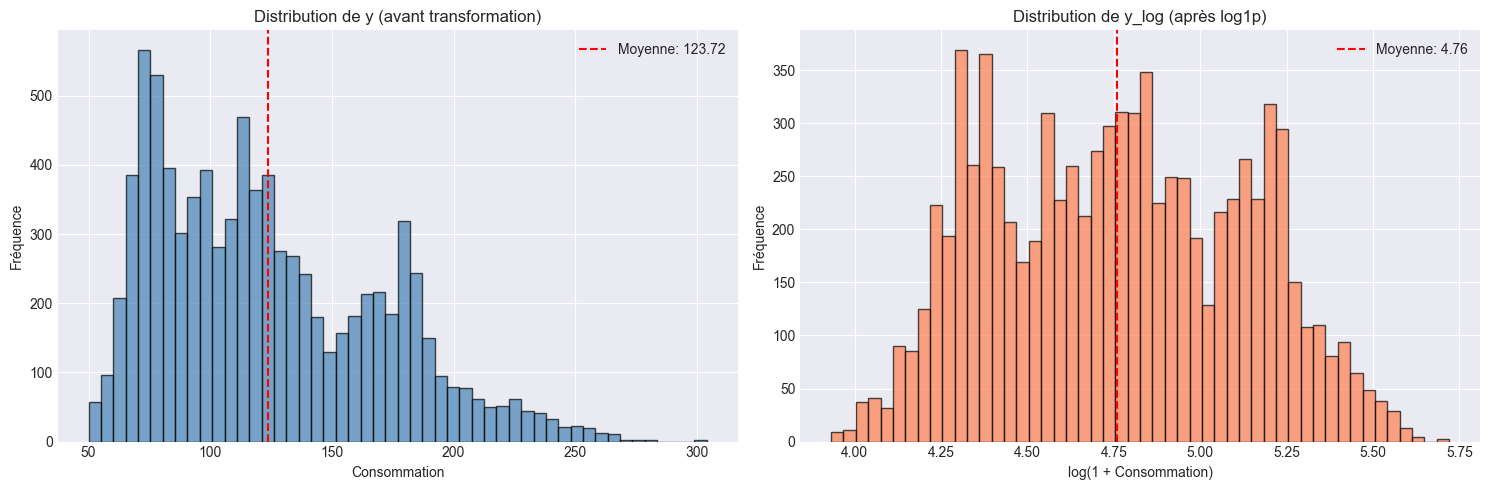

Statistiques avant/après transformation :
  Avant - Skewness: 0.825
  Après - Skewness: 0.843
  ✓ Transformation appliquée pour stabiliser la variance


In [59]:
# Transformation logarithmique de la variable cible
y_log = np.log1p(y)  # log1p(x) = log(1+x) pour gérer les valeurs proches de 0

# Visualisation de l'impact de la transformation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution avant transformation
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribution de y (avant transformation)')
axes[0].set_xlabel('Consommation')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(y.mean(), color='r', linestyle='--', label=f'Moyenne: {y.mean():.2f}')
axes[0].legend()

# Distribution après transformation
axes[1].hist(y_log, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title('Distribution de y_log (après log1p)')
axes[1].set_xlabel('log(1 + Consommation)')
axes[1].set_ylabel('Fréquence')
axes[1].axvline(y_log.mean(), color='r', linestyle='--', label=f'Moyenne: {y_log.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Comparaison des statistiques
print("Statistiques avant/après transformation :")
print(f"  Avant - Skewness: {np.abs(y - y.mean()).mean() / y.std():.3f}")
print(f"  Après - Skewness: {np.abs(y_log - y_log.mean()).mean() / y_log.std():.3f}")
print(f"  ✓ Transformation appliquée pour stabiliser la variance")


### 5.3. Split train/test séquentiel

Pour les données temporelles, on utilise un split séquentiel (pas de shuffle) pour préserver l'ordre chronologique.


✓ Split séquentiel effectué
  - Train: 6844 observations (80.0%)
  - Test: 1712 observations (20.0%)
  - Période train: indices 0 à 6843
  - Période test: indices 6844 à 8555

Variables créées :
  - y_train_log, y_test_log : avec transformation logarithmique (pour MLP, XGBoost, etc.)
  - y_train, y_test : sans transformation (pour ARIMA)
  - y_test_real : identique à y_test (pour évaluation)


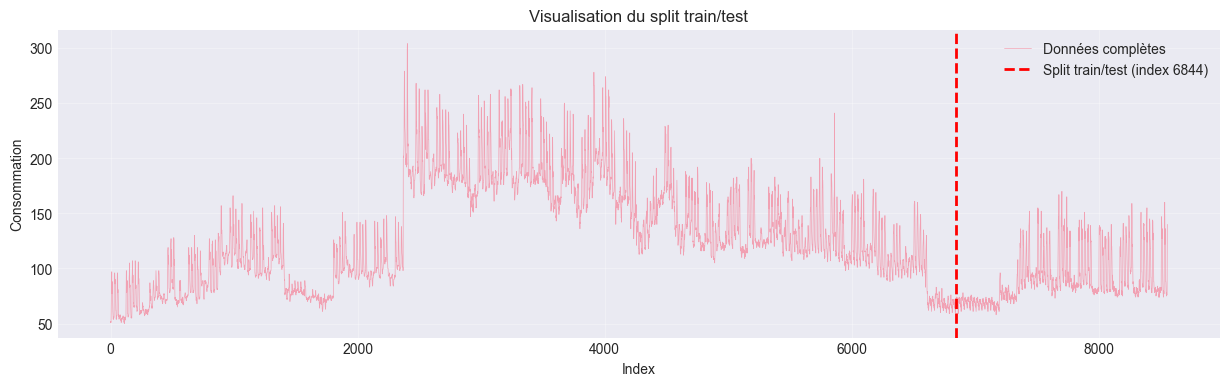

In [60]:
# Split séquentiel (80% train, 20% test)
test_size = 0.2
split_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:split_index], X[split_index:]
y_train_log, y_test_log = y_log[:split_index], y_log[split_index:]
y_test_real = y[split_index:]  # On garde aussi les valeurs réelles pour l'évaluation

# Variables sans transformation logarithmique (pour ARIMA notamment)
y_train = y[:split_index]  # y_train sans log pour ARIMA
y_test = y[split_index:]   # y_test sans log (identique à y_test_real, mais nommé pour clarté)

print(f"✓ Split séquentiel effectué")
print(f"  - Train: {len(X_train)} observations ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test: {len(X_test)} observations ({len(X_test)/len(X)*100:.1f}%)")
print(f"  - Période train: indices 0 à {split_index-1}")
print(f"  - Période test: indices {split_index} à {len(X)-1}")
print(f"\nVariables créées :")
print(f"  - y_train_log, y_test_log : avec transformation logarithmique (pour MLP, XGBoost, etc.)")
print(f"  - y_train, y_test : sans transformation (pour ARIMA)")
print(f"  - y_test_real : identique à y_test (pour évaluation)")

# Visualisation du split
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(range(len(y)), y, alpha=0.6, linewidth=0.5, label='Données complètes')
ax.axvline(split_index, color='r', linestyle='--', linewidth=2, label=f'Split train/test (index {split_index})')
ax.set_title('Visualisation du split train/test')
ax.set_xlabel('Index')
ax.set_ylabel('Consommation')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


### 5.4. Normalisation des features

Standardisation des features pour que toutes les variables soient à la même échelle, ce qui améliore les performances des réseaux de neurones.


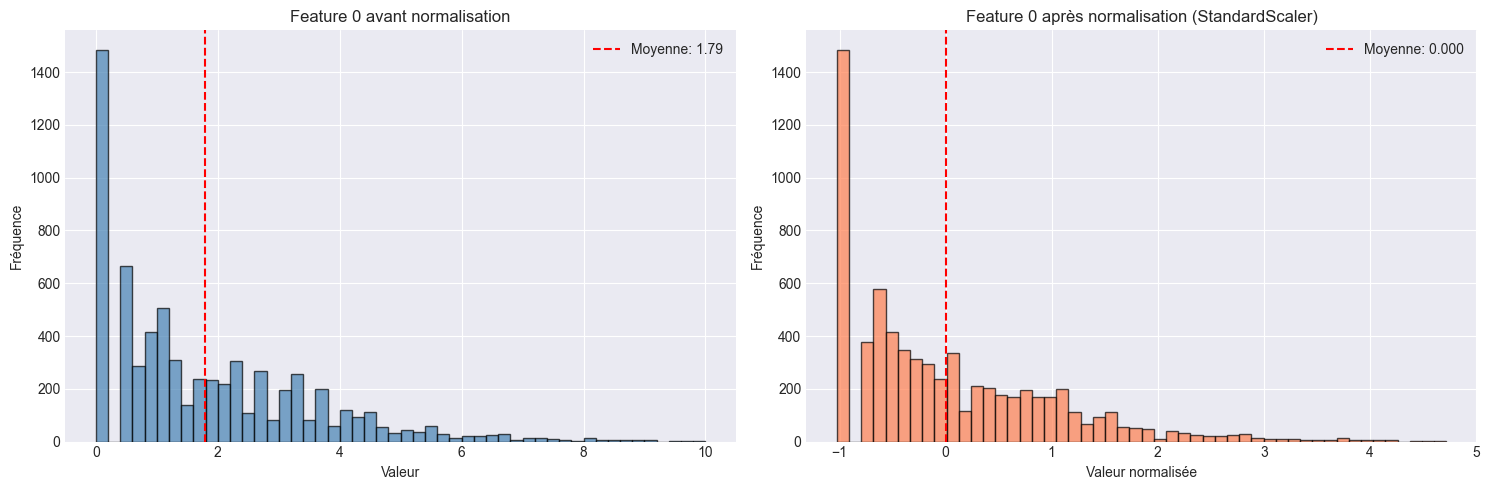

✓ Normalisation effectuée
  - Moyenne train (après scaling): -0.000000 (≈ 0)
  - Écart-type train (après scaling): 1.000000 (≈ 1)


In [61]:
# Normalisation avec StandardScaler (moyenne=0, écart-type=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualisation de l'impact de la normalisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution d'une feature avant normalisation (ex: première variable météo)
feature_idx = 0
axes[0].hist(X_train[:, feature_idx], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title(f'Feature {feature_idx} avant normalisation')
axes[0].set_xlabel('Valeur')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(X_train[:, feature_idx].mean(), color='r', linestyle='--', 
                label=f'Moyenne: {X_train[:, feature_idx].mean():.2f}')
axes[0].legend()

# Distribution après normalisation
axes[1].hist(X_train_scaled[:, feature_idx], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title(f'Feature {feature_idx} après normalisation (StandardScaler)')
axes[1].set_xlabel('Valeur normalisée')
axes[1].set_ylabel('Fréquence')
axes[1].axvline(X_train_scaled[:, feature_idx].mean(), color='r', linestyle='--', 
                label=f'Moyenne: {X_train_scaled[:, feature_idx].mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"✓ Normalisation effectuée")
print(f"  - Moyenne train (après scaling): {X_train_scaled.mean():.6f} (≈ 0)")
print(f"  - Écart-type train (après scaling): {X_train_scaled.std():.6f} (≈ 1)")


## 6. Modélisation

### 6.1. Configuration et entraînement du modèle MLP

Utilisation d'un Multi-Layer Perceptron (réseau de neurones) pour capturer les relations non-linéaires complexes entre les features et la consommation.


In [62]:
# Configuration du modèle MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 100, 50),  # Architecture: 3 couches cachées
    activation='relu',                   # Fonction d'activation ReLU
    solver='adam',                       # Optimiseur Adam
    max_iter=2000,                       # Nombre maximum d'itérations
    early_stopping=True,                 # Arrêt anticipé si pas d'amélioration
    n_iter_no_change=20,                # Nombre d'itérations sans amélioration avant arrêt
    alpha=0.5,                         # Régularisation L2
)

print("Configuration du modèle MLP:")
print(f"  - Architecture: {mlp.hidden_layer_sizes}")
print(f"  - Activation: {mlp.activation}")
print(f"  - Optimiseur: {mlp.solver}")
print(f"  - Régularisation (alpha): {mlp.alpha}")
print(f"  - Early stopping: {mlp.early_stopping}")

# Entraînement du modèle
print("\n⏳ Entraînement en cours...")
mlp.fit(X_train_scaled, y_train_log)
print("✓ Modèle entraîné avec succès")


Configuration du modèle MLP:
  - Architecture: (100, 100, 50)
  - Activation: relu
  - Optimiseur: adam
  - Régularisation (alpha): 0.5
  - Early stopping: True

⏳ Entraînement en cours...


✓ Modèle entraîné avec succès


### 6.2. Analyse de la courbe d'apprentissage

Visualisation de l'évolution de la loss pendant l'entraînement pour détecter le surapprentissage ou le sous-apprentissage.


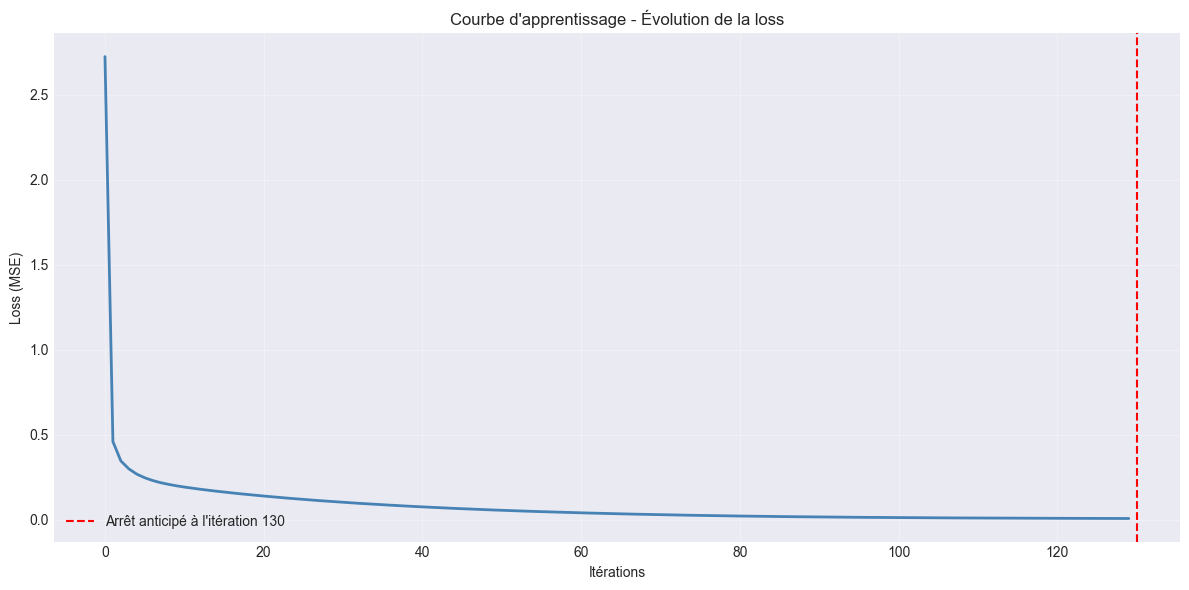

✓ Nombre d'itérations effectuées: 130
  - Loss finale: 0.007399
  - Amélioration: 99.73%


In [63]:
# Récupération de la courbe de loss
if hasattr(mlp, 'loss_curve_'):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(mlp.loss_curve_, linewidth=2, color='steelblue')
    ax.set_title('Courbe d\'apprentissage - Évolution de la loss')
    ax.set_xlabel('Itérations')
    ax.set_ylabel('Loss (MSE)')
    ax.grid(True, alpha=0.3)
    
    # Marquer le point d'arrêt si early stopping a été utilisé
    if mlp.n_iter_ < mlp.max_iter:
        ax.axvline(mlp.n_iter_, color='r', linestyle='--', 
                   label=f'Arrêt anticipé à l\'itération {mlp.n_iter_}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Nombre d'itérations effectuées: {mlp.n_iter_}")
    print(f"  - Loss finale: {mlp.loss_curve_[-1]:.6f}")
    if len(mlp.loss_curve_) > 1:
        print(f"  - Amélioration: {((mlp.loss_curve_[0] - mlp.loss_curve_[-1]) / mlp.loss_curve_[0] * 100):.2f}%")
else:
    print("⚠ Courbe de loss non disponible (peut nécessiter validation_fraction > 0)")


### 📊 Interprétation & Pistes d'amélioration - Modélisation

**Observations clés :**
- La courbe d'apprentissage montre si le modèle converge correctement
- L'early stopping permet d'éviter le surapprentissage
- L'architecture (100, 100, 50) peut être optimisée selon les performances

**Pistes d'amélioration :**
- Tester différentes architectures (plus profondes, plus larges, ou dropout)
- Ajuster les hyperparamètres (learning_rate, alpha, batch_size)
- Utiliser la validation croisée temporelle (TimeSeriesSplit) pour mieux évaluer
- Tester d'autres modèles (XGBoost, LSTM pour séries temporelles, ensemble methods)


## 7. Évaluation du Modèle

### 7.1. Prédictions et inversion de la transformation

Les prédictions sont faites sur l'échelle logarithmique, puis inversées pour revenir à l'échelle originale.


In [64]:
# Prédictions sur l'échelle logarithmique
y_pred_test_log = mlp.predict(X_test_scaled)

# Inversion de la transformation logarithmique
y_pred_test = np.expm1(y_pred_test_log)  # expm1(x) = exp(x) - 1, inverse de log1p

print("✓ Prédictions générées et transformées")
print(f"  - Nombre de prédictions: {len(y_pred_test)}")
print(f"  - Min prédit: {y_pred_test.min():.2f}, Max prédit: {y_pred_test.max():.2f}")
print(f"  - Min réel: {y_test_real.min():.2f}, Max réel: {y_test_real.max():.2f}")


✓ Prédictions générées et transformées
  - Nombre de prédictions: 1712
  - Min prédit: 62.20, Max prédit: 167.81
  - Min réel: 58.00, Max réel: 170.00


### 7.2. Calcul des métriques d'évaluation

Calcul des métriques principales pour évaluer la performance du modèle : RMSE, MAE, et MAPE.


RÉSULTATS FINAUX - ÉVALUATION SUR LE TEST SET
RMSE Test : 6.43 (Root Mean Squared Error)
MAE Test  : 4.57 (Mean Absolute Error)
MAPE Test : 4.76% (Mean Absolute Percentage Error)


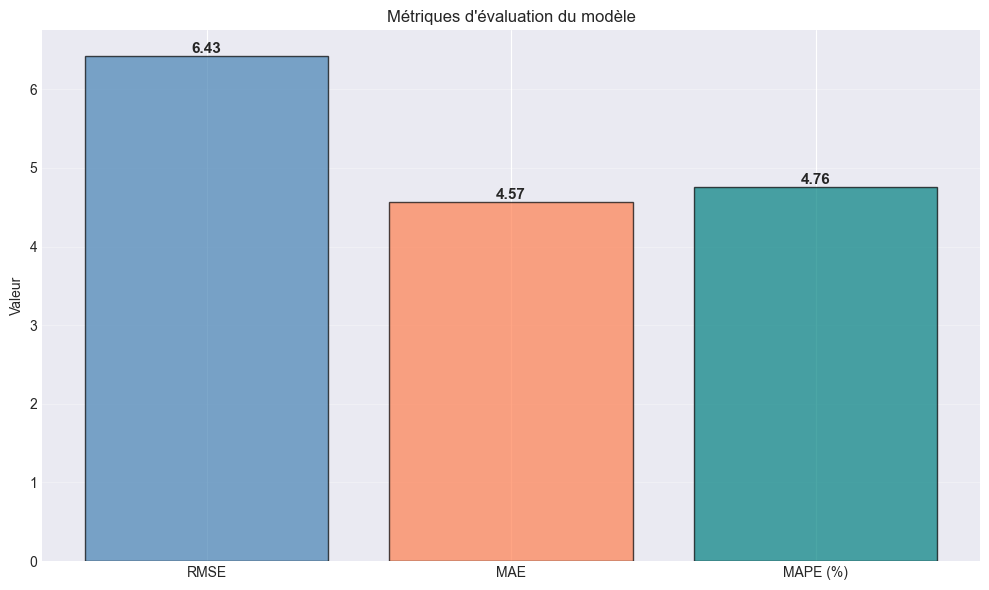

In [65]:
# Calcul des métriques
rmse_test = np.sqrt(mean_squared_error(y_test_real, y_pred_test))
mae_test = mean_absolute_error(y_test_real, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test_real, y_pred_test) * 100

# Affichage des résultats
print("=" * 50)
print("RÉSULTATS FINAUX - ÉVALUATION SUR LE TEST SET")
print("=" * 50)
print(f"RMSE Test : {rmse_test:.2f} (Root Mean Squared Error)")
print(f"MAE Test  : {mae_test:.2f} (Mean Absolute Error)")
print(f"MAPE Test : {mape_test:.2f}% (Mean Absolute Percentage Error)")
print("=" * 50)

# Visualisation des métriques
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['RMSE', 'MAE', 'MAPE (%)']
values = [rmse_test, mae_test, mape_test]
colors = ['steelblue', 'coral', 'teal']

bars = ax.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Métriques d\'évaluation du modèle')
ax.set_ylabel('Valeur')
ax.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### 7.3. Visualisation des prédictions vs valeurs réelles

Comparaison visuelle des prédictions avec les valeurs réelles pour identifier les patterns d'erreur.


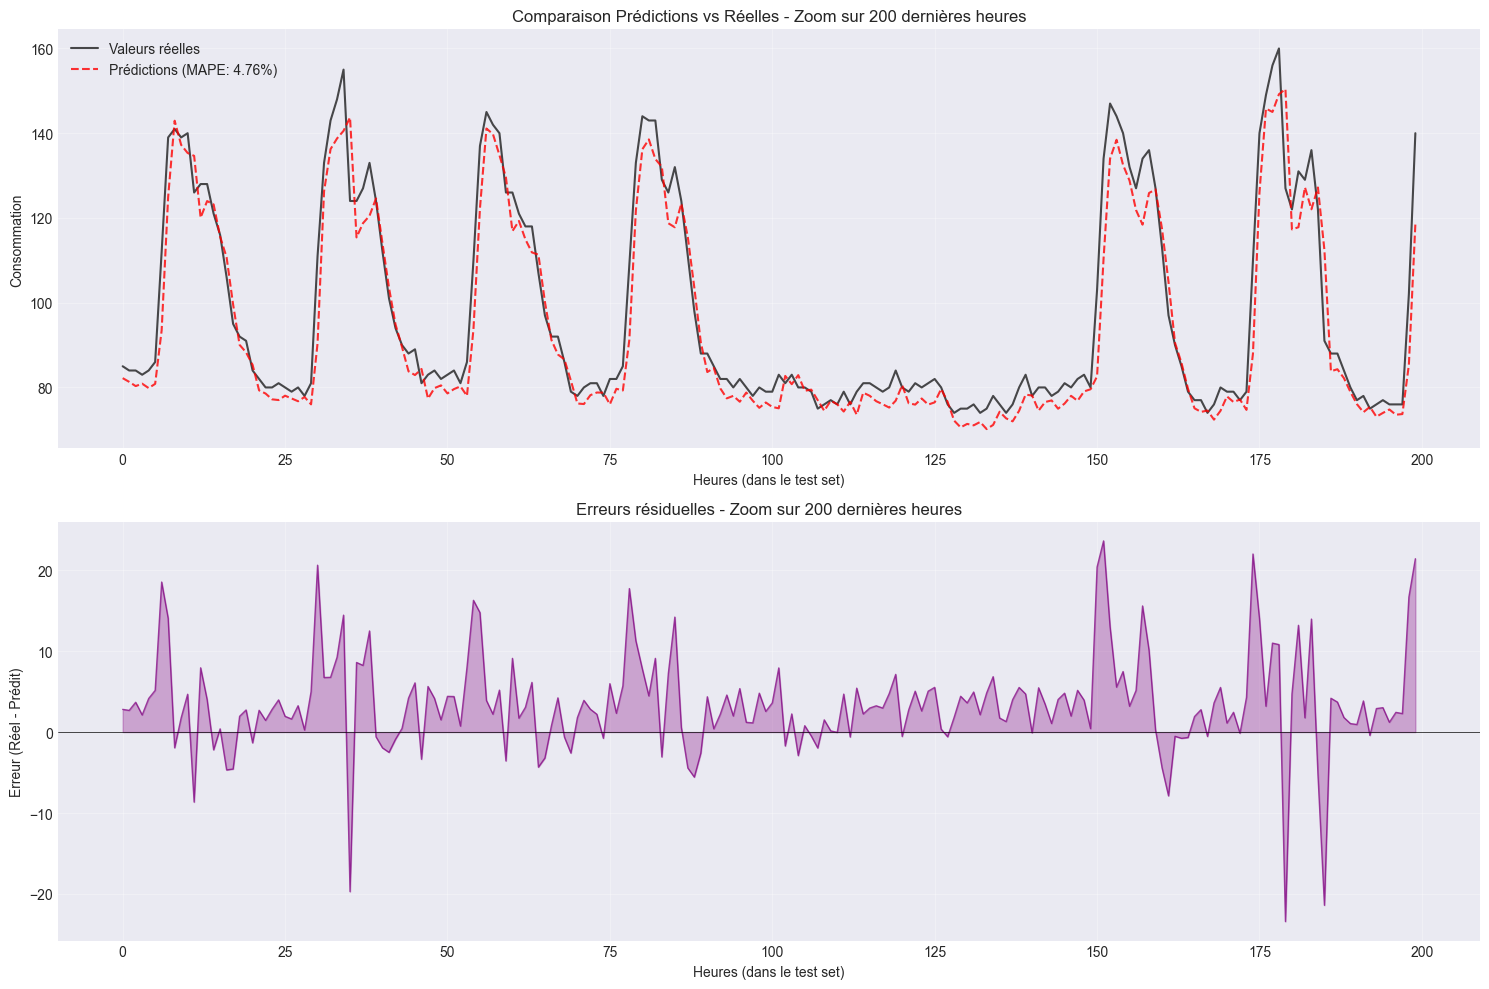

In [66]:
# Graphique temporel : prédictions vs réelles (zoom sur les 200 dernières heures)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Zoom sur 200 heures
zoom_size = 200
axes[0].plot(y_test_real[-zoom_size:], label="Valeurs réelles", 
             color='black', alpha=0.7, linewidth=1.5)
axes[0].plot(y_pred_test[-zoom_size:], label=f"Prédictions (MAPE: {mape_test:.2f}%)", 
             color='red', linestyle='--', linewidth=1.5, alpha=0.8)
axes[0].set_title(f'Comparaison Prédictions vs Réelles - Zoom sur {zoom_size} dernières heures')
axes[0].set_xlabel('Heures (dans le test set)')
axes[0].set_ylabel('Consommation')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Erreurs résiduelles
errors = y_test_real[-zoom_size:] - y_pred_test[-zoom_size:]
axes[1].plot(errors, color='purple', alpha=0.7, linewidth=1)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].fill_between(range(len(errors)), errors, 0, alpha=0.3, color='purple')
axes[1].set_title(f'Erreurs résiduelles - Zoom sur {zoom_size} dernières heures')
axes[1].set_xlabel('Heures (dans le test set)')
axes[1].set_ylabel('Erreur (Réel - Prédit)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 7.4. Scatter plot et analyse de corrélation

Analyse de la corrélation entre prédictions et valeurs réelles pour évaluer la qualité du modèle.


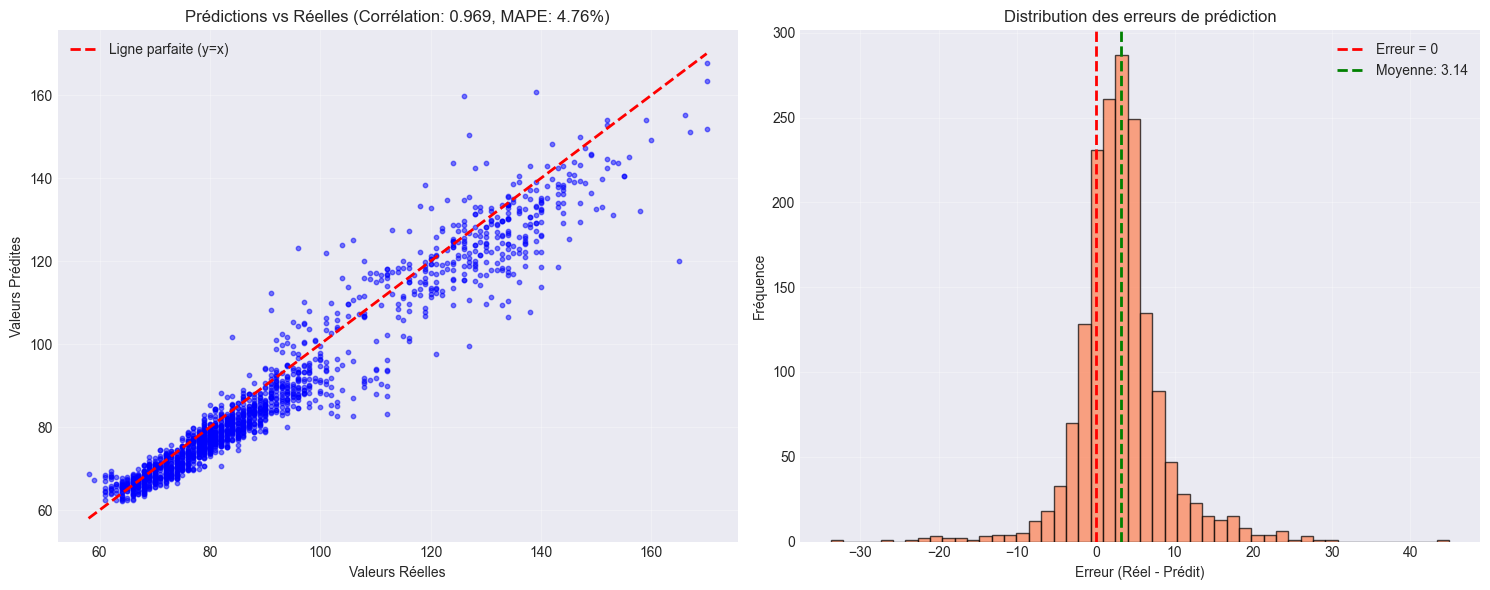


Analyse des erreurs :
  - Erreur moyenne: 3.14 (idéalement proche de 0)
  - Écart-type des erreurs: 5.61
  - Corrélation prédictions/réelles: 0.9692
  ⚠ Le modèle présente un biais (erreur moyenne ≠ 0)


In [67]:
# Scatter plot : Prédictions vs Réelles
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot avec ligne parfaite
correlation = np.corrcoef(y_test_real, y_pred_test)[0, 1]
axes[0].scatter(y_test_real, y_pred_test, alpha=0.5, color='blue', s=10)
axes[0].plot([y_test_real.min(), y_test_real.max()], 
             [y_test_real.min(), y_test_real.max()], 
             'r--', lw=2, label='Ligne parfaite (y=x)')
axes[0].set_xlabel('Valeurs Réelles')
axes[0].set_ylabel('Valeurs Prédites')
axes[0].set_title(f'Prédictions vs Réelles (Corrélation: {correlation:.3f}, MAPE: {mape_test:.2f}%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution des erreurs
errors_all = y_test_real - y_pred_test
axes[1].hist(errors_all, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2, label='Erreur = 0')
axes[1].axvline(errors_all.mean(), color='g', linestyle='--', linewidth=2, 
                label=f'Moyenne: {errors_all.mean():.2f}')
axes[1].set_title('Distribution des erreurs de prédiction')
axes[1].set_xlabel('Erreur (Réel - Prédit)')
axes[1].set_ylabel('Fréquence')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques des erreurs
print(f"\nAnalyse des erreurs :")
print(f"  - Erreur moyenne: {errors_all.mean():.2f} (idéalement proche de 0)")
print(f"  - Écart-type des erreurs: {errors_all.std():.2f}")
print(f"  - Corrélation prédictions/réelles: {correlation:.4f}")
if abs(errors_all.mean()) < errors_all.std() * 0.1:
    print(f"  ✓ Le modèle ne présente pas de biais significatif")
else:
    print(f"  ⚠ Le modèle présente un biais (erreur moyenne ≠ 0)")


### 7.5. Analyse des erreurs par contexte

Analyse des performances selon différents contextes (heure, jour de la semaine, week-end) pour identifier les situations où le modèle performe moins bien.


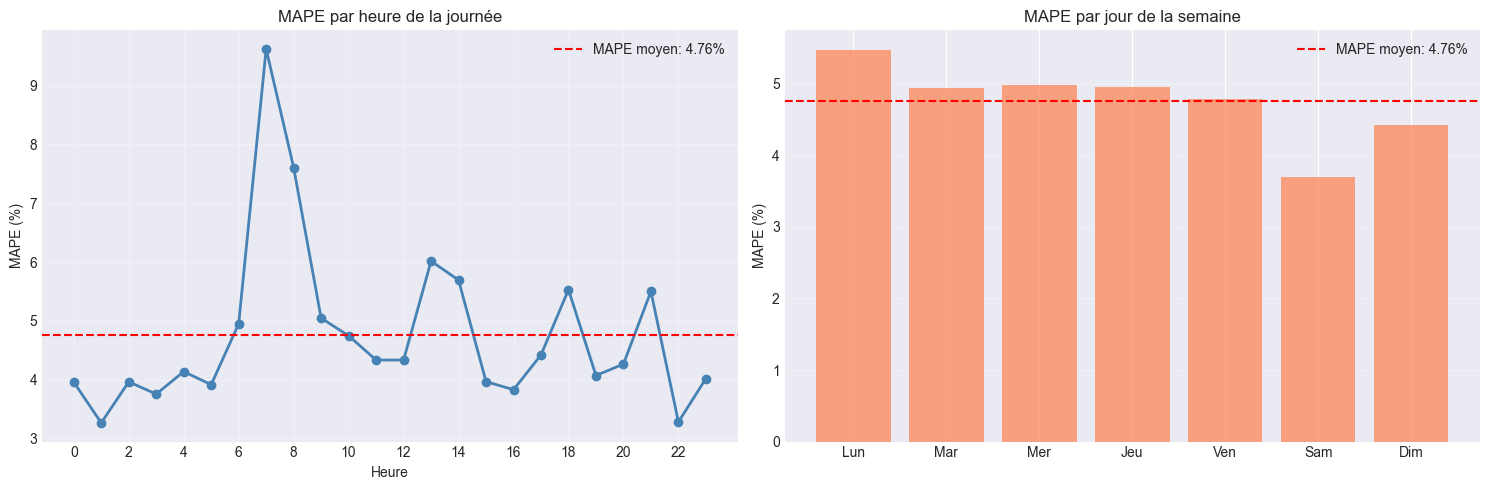


Analyse des performances par contexte :
  - Meilleure heure: 1h (MAPE: 3.26%)
  - Pire heure: 7h (MAPE: 9.62%)
  - Meilleur jour: Sam (MAPE: 3.70%)
  - Pire jour: Lun (MAPE: 5.47%)


In [68]:
# Extraction des contextes pour le test set
test_heures = Heure_orig[168+split_index:]
test_jours_semaine = jours_de_la_semaine[168+split_index:]
test_is_weekend = is_weekend[168+split_index:]

# Calcul du MAPE par contexte
def calculate_mape_by_context(context_values, context_name):
    """Calcule le MAPE pour chaque valeur unique du contexte"""
    unique_values = np.unique(context_values)
    mape_by_context = {}
    for val in unique_values:
        mask = context_values == val
        if mask.sum() > 0:
            mape = mean_absolute_percentage_error(y_test_real[mask], y_pred_test[mask]) * 100
            mape_by_context[val] = mape
    return mape_by_context

# MAPE par heure
mape_by_hour = calculate_mape_by_context(test_heures, "heure")
mape_by_weekday = calculate_mape_by_context(test_jours_semaine, "jour_semaine")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAPE par heure
hours = sorted(mape_by_hour.keys())
mape_hours = [mape_by_hour[h] for h in hours]
axes[0].plot(hours, mape_hours, marker='o', linewidth=2, markersize=6, color='steelblue')
axes[0].axhline(mape_test, color='r', linestyle='--', label=f'MAPE moyen: {mape_test:.2f}%')
axes[0].set_title('MAPE par heure de la journée')
axes[0].set_xlabel('Heure')
axes[0].set_ylabel('MAPE (%)')
axes[0].set_xticks(range(0, 24, 2))
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAPE par jour de la semaine
jours_noms = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
jours_idx = sorted(mape_by_weekday.keys())
mape_days = [mape_by_weekday[j] for j in jours_idx]
axes[1].bar(jours_noms, mape_days, color='coral', alpha=0.7)
axes[1].axhline(mape_test, color='r', linestyle='--', label=f'MAPE moyen: {mape_test:.2f}%')
axes[1].set_title('MAPE par jour de la semaine')
axes[1].set_ylabel('MAPE (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Identification des heures/jours avec les meilleures/pires performances
worst_hour = max(mape_by_hour, key=mape_by_hour.get)
best_hour = min(mape_by_hour, key=mape_by_hour.get)
worst_day = max(mape_by_weekday, key=mape_by_weekday.get)
best_day = min(mape_by_weekday, key=mape_by_weekday.get)

print(f"\nAnalyse des performances par contexte :")
print(f"  - Meilleure heure: {best_hour}h (MAPE: {mape_by_hour[best_hour]:.2f}%)")
print(f"  - Pire heure: {worst_hour}h (MAPE: {mape_by_hour[worst_hour]:.2f}%)")
print(f"  - Meilleur jour: {jours_noms[best_day]} (MAPE: {mape_by_weekday[best_day]:.2f}%)")
print(f"  - Pire jour: {jours_noms[worst_day]} (MAPE: {mape_by_weekday[worst_day]:.2f}%)")


## Phase 2 : Optimisation et Comparaison de Modèles

Cette phase présente une approche systématique pour optimiser et comparer différents modèles de machine learning afin d'améliorer les performances de prédiction.

### Objectifs :
- Optimiser les hyperparamètres du MLP existant
- Tester et comparer différents algorithmes de ML
- Évaluer des modèles spécialisés pour séries temporelles
- Implémenter des méthodes d'ensemble pour améliorer la robustesse


### Phase 2.1 : Hyperparameter Tuning pour MLP

**Objectif** : Optimiser les hyperparamètres du MLP existant pour améliorer les performances.

**Méthodes** : GridSearchCV et/ou RandomSearchCV pour explorer l'espace des hyperparamètres.


In [69]:
# Les imports nécessaires sont déjà effectués dans la cellule principale (section 1)
# GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, time, uniform, randint sont disponibles
print("✓ Imports pour optimisation déjà effectués")


✓ Imports pour optimisation déjà effectués


In [70]:
# Évaluation du modèle MLP de base (référence)
print("=" * 60)
print("MODÈLE MLP DE BASE (RÉFÉRENCE)")
print("=" * 60)

mlp_baseline = MLPRegressor(
    hidden_layer_sizes=(100, 100, 50),
    activation='relu',
    solver='adam',
    max_iter=2000,
    early_stopping=True,
    n_iter_no_change=20,
    alpha=0.5,
    random_state=42
)

start_time = time.time()
mlp_baseline.fit(X_train_scaled, y_train_log)
training_time_baseline = time.time() - start_time

y_pred_baseline_log = mlp_baseline.predict(X_test_scaled)
y_pred_baseline = np.expm1(y_pred_baseline_log)

rmse_baseline = np.sqrt(mean_squared_error(y_test_real, y_pred_baseline))
mae_baseline = mean_absolute_error(y_test_real, y_pred_baseline)
mape_baseline = mean_absolute_percentage_error(y_test_real, y_pred_baseline) * 100

print(f"RMSE : {rmse_baseline:.2f}")
print(f"MAE  : {mae_baseline:.2f}")
print(f"MAPE : {mape_baseline:.2f}%")
print(f"Temps d'entraînement : {training_time_baseline:.2f}s")
print("=" * 60)

# Stockage des résultats pour comparaison
results_comparison = {
    'MLP Baseline': {
        'RMSE': rmse_baseline,
        'MAE': mae_baseline,
        'MAPE': mape_baseline,
        'Training Time': training_time_baseline
    }
}


MODÈLE MLP DE BASE (RÉFÉRENCE)
RMSE : 6.43
MAE  : 4.57
MAPE : 4.76%
Temps d'entraînement : 54.23s


#### 2.1.1 : GridSearchCV pour optimisation exhaustive

Recherche exhaustive sur une grille d'hyperparamètres prédéfinie.


In [71]:
# Définition de la grille d'hyperparamètres pour GridSearchCV
# Note : On utilise une grille réduite pour limiter le temps de calcul
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100, 50), (150, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.1, 0.5, 1.0],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [32, 64, 128]
}

# Utilisation de TimeSeriesSplit pour préserver l'ordre temporel
tscv = TimeSeriesSplit(n_splits=3)

print("⏳ GridSearchCV en cours... (cela peut prendre plusieurs minutes)")
print(f"  - Nombre de combinaisons à tester : {np.prod([len(v) for v in param_grid_mlp.values()])}")
print(f"  - Cross-validation : {tscv.n_splits} folds")

mlp_grid = MLPRegressor(
    solver='adam',
    max_iter=500,  # Réduit pour accélérer le grid search
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42
)

start_time = time.time()
grid_search = GridSearchCV(
    mlp_grid,
    param_grid_mlp,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train_log)
grid_search_time = time.time() - start_time

print(f"\n✓ GridSearchCV terminé en {grid_search_time/60:.2f} minutes")
print(f"\nMeilleurs hyperparamètres trouvés :")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nMeilleur score (CV) : {-grid_search.best_score_:.6f} (MSE négative)")

# Évaluation du meilleur modèle
mlp_optimized = grid_search.best_estimator_
y_pred_optimized_log = mlp_optimized.predict(X_test_scaled)
y_pred_optimized = np.expm1(y_pred_optimized_log)

rmse_optimized = np.sqrt(mean_squared_error(y_test_real, y_pred_optimized))
mae_optimized = mean_absolute_error(y_test_real, y_pred_optimized)
mape_optimized = mean_absolute_percentage_error(y_test_real, y_pred_optimized) * 100

print(f"\n📊 Performances sur le test set :")
print(f"  RMSE : {rmse_optimized:.2f} (baseline: {rmse_baseline:.2f})")
print(f"  MAE  : {mae_optimized:.2f} (baseline: {mae_baseline:.2f})")
print(f"  MAPE : {mape_optimized:.2f}% (baseline: {mape_baseline:.2f}%)")

improvement_rmse = ((rmse_baseline - rmse_optimized) / rmse_baseline) * 100
improvement_mape = ((mape_baseline - mape_optimized) / mape_baseline) * 100

print(f"\n📈 Amélioration :")
print(f"  RMSE : {improvement_rmse:+.2f}%")
print(f"  MAPE : {improvement_mape:+.2f}%")

# Stockage des résultats
results_comparison['MLP Optimized (GridSearch)'] = {
    'RMSE': rmse_optimized,
    'MAE': mae_optimized,
    'MAPE': mape_optimized,
    'Training Time': grid_search_time
}


⏳ GridSearchCV en cours... (cela peut prendre plusieurs minutes)
  - Nombre de combinaisons à tester : 144
  - Cross-validation : 3 folds
Fitting 3 folds for each of 144 candidates, totalling 432 fits

✓ GridSearchCV terminé en 21.94 minutes

Meilleurs hyperparamètres trouvés :
  - activation: tanh
  - alpha: 0.5
  - batch_size: 32
  - hidden_layer_sizes: (50, 50)
  - learning_rate_init: 0.01

Meilleur score (CV) : 0.006806 (MSE négative)

📊 Performances sur le test set :
  RMSE : 9.42 (baseline: 6.43)
  MAE  : 6.45 (baseline: 4.57)
  MAPE : 6.30% (baseline: 4.76%)

📈 Amélioration :
  RMSE : -46.51%
  MAPE : -32.41%


#### 2.1.2 : Visualisation des résultats du tuning

Analyse des résultats du GridSearchCV pour comprendre l'impact des différents hyperparamètres.


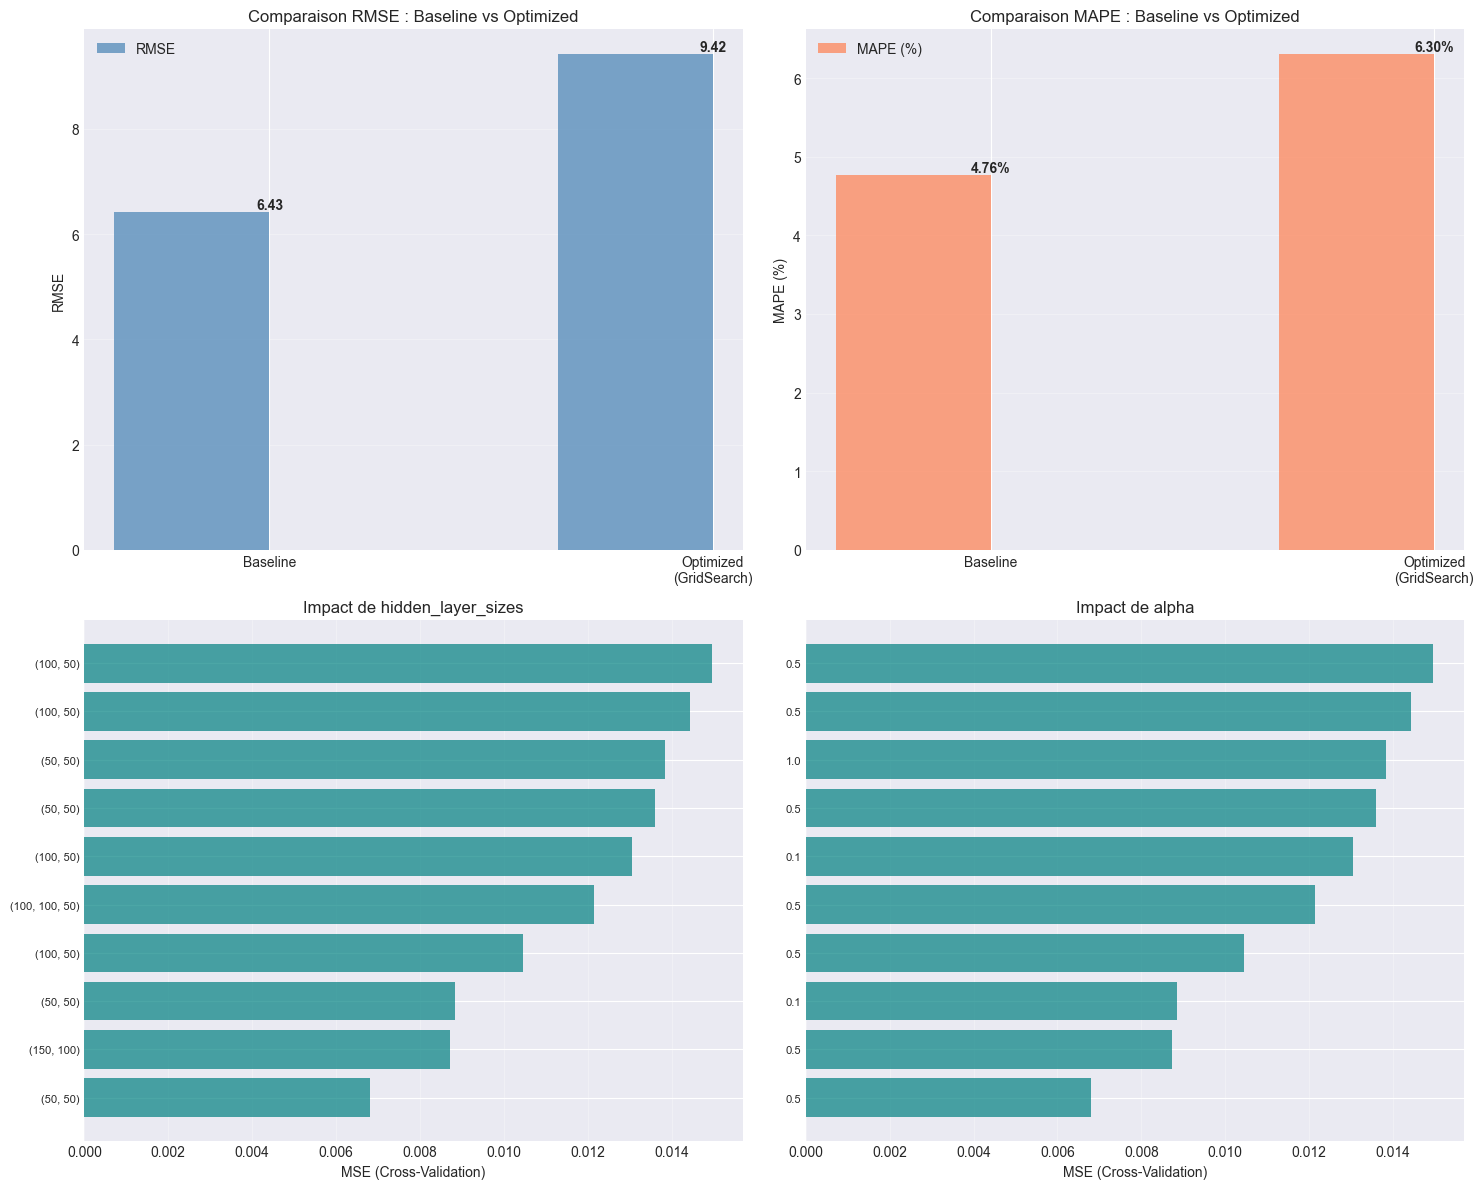

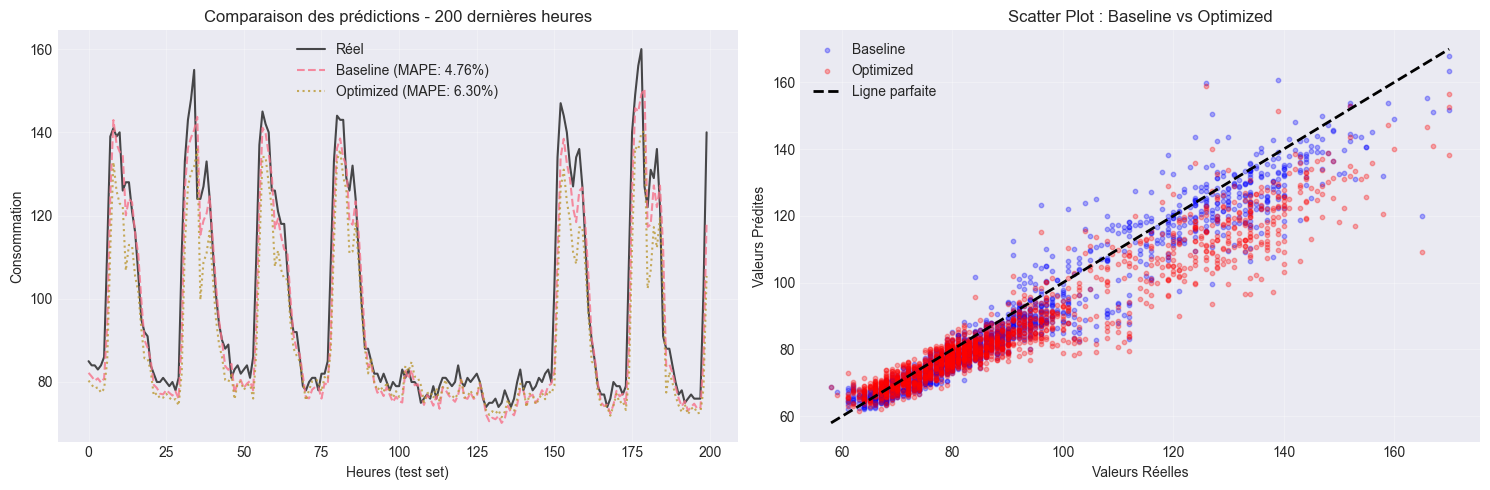

✓ Visualisations créées


In [72]:
# Visualisation des résultats du GridSearchCV
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Comparaison Baseline vs Optimized
models = ['Baseline', 'Optimized\n(GridSearch)']
rmse_values = [rmse_baseline, rmse_optimized]
mape_values = [mape_baseline, mape_optimized]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, rmse_values, width, label='RMSE', color='steelblue', alpha=0.7)
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Comparaison RMSE : Baseline vs Optimized')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_values):
    axes[0, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

axes[0, 1].bar(x - width/2, mape_values, width, label='MAPE (%)', color='coral', alpha=0.7)
axes[0, 1].set_ylabel('MAPE (%)')
axes[0, 1].set_title('Comparaison MAPE : Baseline vs Optimized')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mape_values):
    axes[0, 1].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. Impact des hyperparamètres (si disponible dans les résultats)
results_df = grid_search.cv_results_
param_names = ['hidden_layer_sizes', 'alpha', 'learning_rate_init']

# Extraction des scores moyens pour chaque paramètre
for idx, param_name in enumerate(param_names):
    if idx < 2:  # On affiche seulement 2 paramètres
        row, col = (1, idx)
        param_values = results_df[f'param_{param_name}']
        mean_scores = -results_df['mean_test_score']  # Conversion en MSE positive
        
        # Trier par score pour meilleure visualisation
        sorted_indices = np.argsort(mean_scores)
        param_values_sorted = [str(param_values[i]) for i in sorted_indices[:10]]  # Top 10
        scores_sorted = mean_scores[sorted_indices][:10]
        
        axes[row, col].barh(range(len(param_values_sorted)), scores_sorted, color='teal', alpha=0.7)
        axes[row, col].set_yticks(range(len(param_values_sorted)))
        axes[row, col].set_yticklabels(param_values_sorted, fontsize=8)
        axes[row, col].set_xlabel('MSE (Cross-Validation)')
        axes[row, col].set_title(f'Impact de {param_name}')
        axes[row, col].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# 3. Comparaison des prédictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sample_size = 200
axes[0].plot(y_test_real[-sample_size:], label='Réel', color='black', linewidth=1.5, alpha=0.7)
axes[0].plot(y_pred_baseline[-sample_size:], label=f'Baseline (MAPE: {mape_baseline:.2f}%)', 
             linestyle='--', linewidth=1.5, alpha=0.8)
axes[0].plot(y_pred_optimized[-sample_size:], label=f'Optimized (MAPE: {mape_optimized:.2f}%)', 
             linestyle=':', linewidth=1.5, alpha=0.8)
axes[0].set_title(f'Comparaison des prédictions - {sample_size} dernières heures')
axes[0].set_xlabel('Heures (test set)')
axes[0].set_ylabel('Consommation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot : Baseline vs Optimized
axes[1].scatter(y_test_real, y_pred_baseline, alpha=0.3, s=10, label='Baseline', color='blue')
axes[1].scatter(y_test_real, y_pred_optimized, alpha=0.3, s=10, label='Optimized', color='red')
axes[1].plot([y_test_real.min(), y_test_real.max()], 
             [y_test_real.min(), y_test_real.max()], 
             'k--', lw=2, label='Ligne parfaite')
axes[1].set_xlabel('Valeurs Réelles')
axes[1].set_ylabel('Valeurs Prédites')
axes[1].set_title('Scatter Plot : Baseline vs Optimized')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualisations créées")


### Phase 2.2 : Test de Modèles Alternatifs

**Objectif** : Comparer différents algorithmes de machine learning pour identifier le meilleur modèle.

**Modèles testés** : XGBoost, LightGBM, Random Forest


In [73]:
# Les imports nécessaires sont déjà effectués dans la cellule principale (section 1)
# XGBRegressor, LGBMRegressor, RandomForestRegressor sont disponibles
# Les variables XGBOOST_AVAILABLE et LIGHTGBM_AVAILABLE sont déjà définies
print("✓ Imports pour modèles alternatifs déjà effectués")


✓ Imports pour modèles alternatifs déjà effectués


In [74]:
# Fonction helper pour entraîner et évaluer un modèle
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    """Entraîne un modèle et retourne les métriques"""
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    return {
        'model': model,
        'y_pred': y_pred,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Training Time': training_time
    }

print("✓ Fonction helper créée")


✓ Fonction helper créée


#### 2.2.1 : Random Forest Regressor


In [75]:
print("=" * 60)
print("RANDOM FOREST REGRESSOR")
print("=" * 60)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_results = train_and_evaluate_model(
    rf_model, 'Random Forest', 
    X_train_scaled, y_train_log, 
    X_test_scaled, y_test_real
)

print(f"RMSE : {rf_results['RMSE']:.2f}")
print(f"MAE  : {rf_results['MAE']:.2f}")
print(f"MAPE : {rf_results['MAPE']:.2f}%")
print(f"Temps d'entraînement : {rf_results['Training Time']:.2f}s")
print("=" * 60)

results_comparison['Random Forest'] = {
    'RMSE': rf_results['RMSE'],
    'MAE': rf_results['MAE'],
    'MAPE': rf_results['MAPE'],
    'Training Time': rf_results['Training Time']
}


RANDOM FOREST REGRESSOR
RMSE : 5.77
MAE  : 3.79
MAPE : 3.92%
Temps d'entraînement : 4.50s


#### 2.2.2 : XGBoost Regressor


In [76]:
if XGBOOST_AVAILABLE:
    print("=" * 60)
    print("XGBOOST REGRESSOR")
    print("=" * 60)
    
    xgb_model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_results = train_and_evaluate_model(
        xgb_model, 'XGBoost', 
        X_train_scaled, y_train_log, 
        X_test_scaled, y_test_real
    )
    
    print(f"RMSE : {xgb_results['RMSE']:.2f}")
    print(f"MAE  : {xgb_results['MAE']:.2f}")
    print(f"MAPE : {xgb_results['MAPE']:.2f}%")
    print(f"Temps d'entraînement : {xgb_results['Training Time']:.2f}s")
    print("=" * 60)
    
    results_comparison['XGBoost'] = {
        'RMSE': xgb_results['RMSE'],
        'MAE': xgb_results['MAE'],
        'MAPE': xgb_results['MAPE'],
        'Training Time': xgb_results['Training Time']
    }
else:
    print("⚠ XGBoost non disponible - ignoré")


⚠ XGBoost non disponible - ignoré


#### 2.2.3 : LightGBM Regressor


In [77]:
if LIGHTGBM_AVAILABLE:
    print("=" * 60)
    print("LIGHTGBM REGRESSOR")
    print("=" * 60)
    
    lgbm_model = LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    lgbm_results = train_and_evaluate_model(
        lgbm_model, 'LightGBM', 
        X_train_scaled, y_train_log, 
        X_test_scaled, y_test_real
    )
    
    print(f"RMSE : {lgbm_results['RMSE']:.2f}")
    print(f"MAE  : {lgbm_results['MAE']:.2f}")
    print(f"MAPE : {lgbm_results['MAPE']:.2f}%")
    print(f"Temps d'entraînement : {lgbm_results['Training Time']:.2f}s")
    print("=" * 60)
    
    results_comparison['LightGBM'] = {
        'RMSE': lgbm_results['RMSE'],
        'MAE': lgbm_results['MAE'],
        'MAPE': lgbm_results['MAPE'],
        'Training Time': lgbm_results['Training Time']
    }
else:
    print("⚠ LightGBM non disponible - ignoré")


⚠ LightGBM non disponible - ignoré


#### 2.2.4 : Comparaison visuelle des modèles alternatifs



COMPARAISON DES MODÈLES
                                RMSE       MAE      MAPE  Training Time
Random Forest               5.769951  3.787550  3.920024       4.504120
MLP Baseline                6.427466  4.572499  4.760418      54.232175
MLP Optimized (GridSearch)  9.417064  6.451496  6.303295    1316.675720


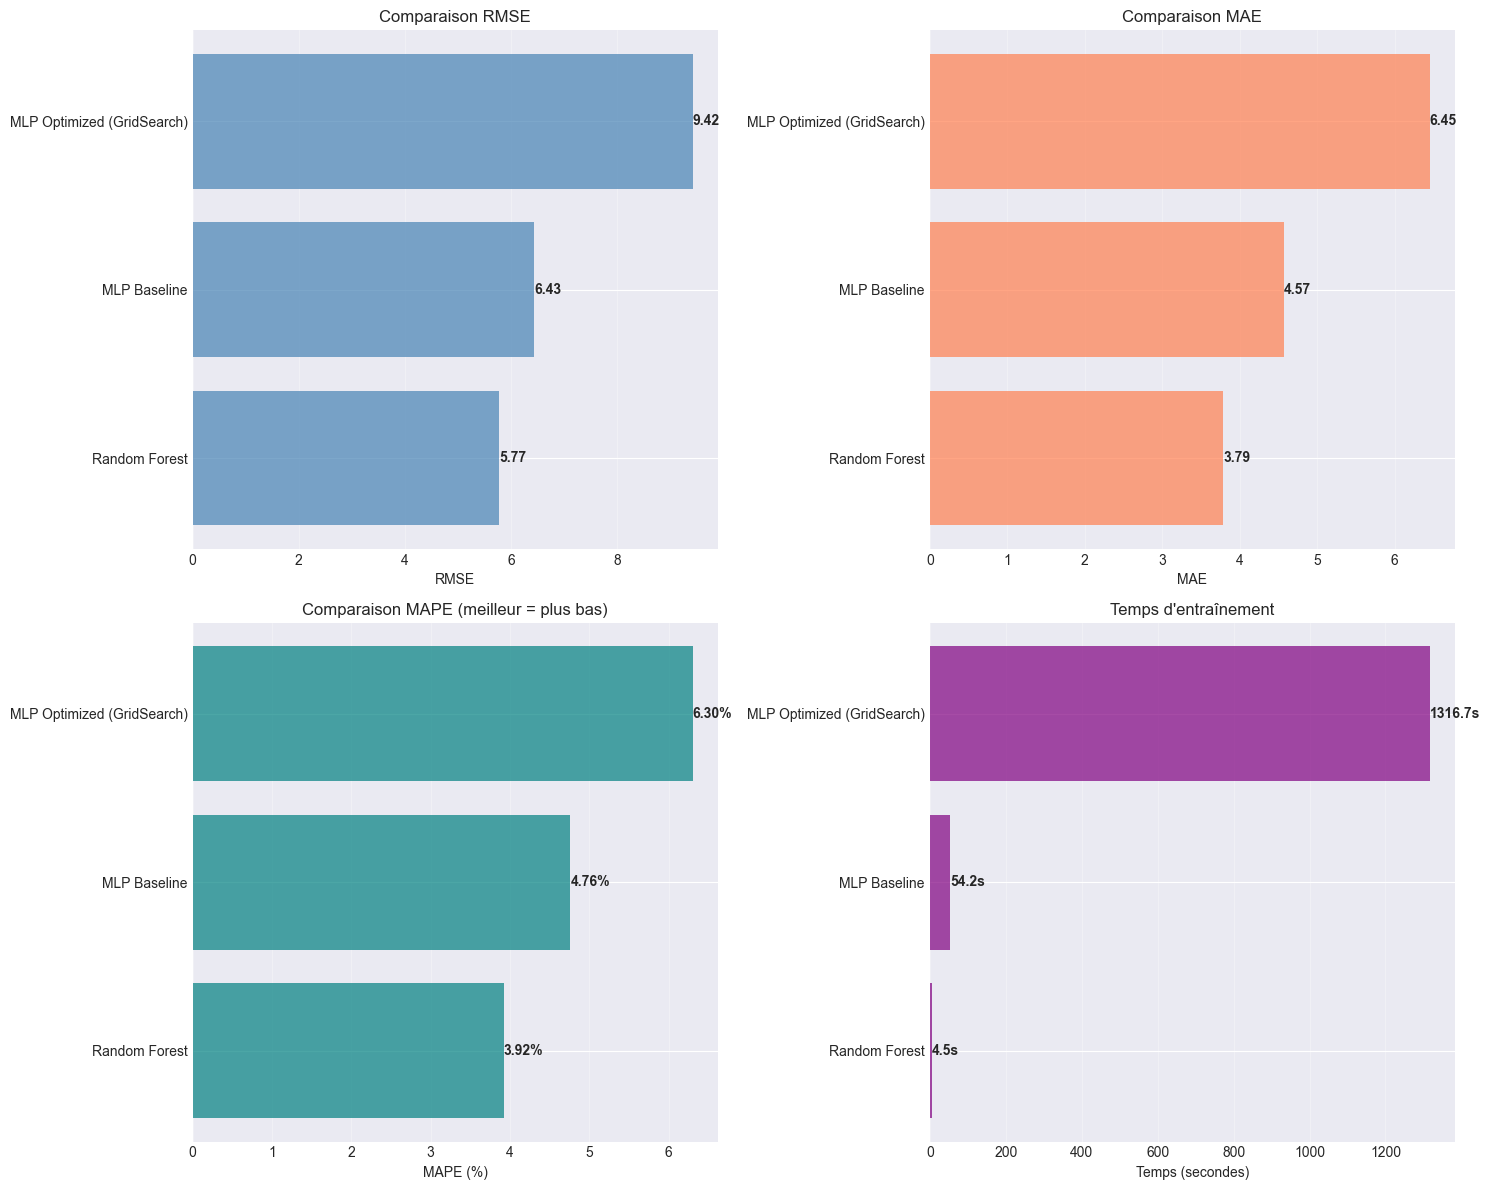


🏆 Meilleur modèle : Random Forest (MAPE: 3.92%)
✓ Comparaison des modèles terminée


In [78]:
# Création d'un DataFrame pour la comparaison
import pandas as pd

comparison_df = pd.DataFrame(results_comparison).T
comparison_df = comparison_df.sort_values('MAPE')

print("\n" + "=" * 60)
print("COMPARAISON DES MODÈLES")
print("=" * 60)
print(comparison_df.to_string())
print("=" * 60)

# Visualisation de la comparaison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

models = comparison_df.index
x_pos = np.arange(len(models))

# 1. RMSE
axes[0, 0].barh(x_pos, comparison_df['RMSE'], color='steelblue', alpha=0.7)
axes[0, 0].set_yticks(x_pos)
axes[0, 0].set_yticklabels(models)
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Comparaison RMSE')
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['RMSE']):
    axes[0, 0].text(v, i, f'{v:.2f}', va='center', ha='left', fontweight='bold')

# 2. MAE
axes[0, 1].barh(x_pos, comparison_df['MAE'], color='coral', alpha=0.7)
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(models)
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Comparaison MAE')
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['MAE']):
    axes[0, 1].text(v, i, f'{v:.2f}', va='center', ha='left', fontweight='bold')

# 3. MAPE
axes[1, 0].barh(x_pos, comparison_df['MAPE'], color='teal', alpha=0.7)
axes[1, 0].set_yticks(x_pos)
axes[1, 0].set_yticklabels(models)
axes[1, 0].set_xlabel('MAPE (%)')
axes[1, 0].set_title('Comparaison MAPE (meilleur = plus bas)')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['MAPE']):
    axes[1, 0].text(v, i, f'{v:.2f}%', va='center', ha='left', fontweight='bold')

# 4. Temps d'entraînement
axes[1, 1].barh(x_pos, comparison_df['Training Time'], color='purple', alpha=0.7)
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(models)
axes[1, 1].set_xlabel('Temps (secondes)')
axes[1, 1].set_title('Temps d\'entraînement')
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['Training Time']):
    axes[1, 1].text(v, i, f'{v:.1f}s', va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Identification du meilleur modèle
best_model_name = comparison_df['MAPE'].idxmin()
best_mape = comparison_df.loc[best_model_name, 'MAPE']
print(f"\n🏆 Meilleur modèle : {best_model_name} (MAPE: {best_mape:.2f}%)")
print("✓ Comparaison des modèles terminée")


### Phase 2.3 : Modèles de Séries Temporelles

**Objectif** : Tester des modèles spécialisés pour les séries temporelles.

**Modèles testés** : LSTM (si disponible), ARIMA/SARIMA


In [79]:
# Les imports nécessaires sont déjà effectués dans la cellule principale (section 1)
# TensorFlow/Keras et statsmodels sont déjà importés
# Les variables TENSORFLOW_AVAILABLE et STATSMODELS_AVAILABLE sont déjà définies
print("✓ Vérification des dépendances déjà effectuée")


✓ Vérification des dépendances déjà effectuée


#### 2.3.1 : LSTM (Long Short-Term Memory)

Les réseaux LSTM sont spécialement conçus pour capturer les dépendances à long terme dans les séries temporelles.


In [80]:
if TENSORFLOW_AVAILABLE:
    print("=" * 60)
    print("LSTM (Long Short-Term Memory)")
    print("=" * 60)
    
    # Préparation des données pour LSTM (format 3D: samples, timesteps, features)
    # On utilise une fenêtre glissante de 24 heures
    def create_lstm_dataset(data, lookback=24):
        """Crée un dataset pour LSTM avec une fenêtre glissante"""
        X_lstm, y_lstm = [], []
        for i in range(lookback, len(data)):
            X_lstm.append(data[i-lookback:i])
            y_lstm.append(data[i])
        return np.array(X_lstm), np.array(y_lstm)
    
    # Utilisation de y_train_log pour LSTM (sans features supplémentaires pour simplifier)
    # On pourrait utiliser X_train_scaled mais cela nécessiterait une architecture plus complexe
    lookback = 24
    X_train_lstm, y_train_lstm = create_lstm_dataset(y_train_log, lookback)
    X_test_lstm, y_test_lstm = create_lstm_dataset(y_test_log, lookback)
    
    # Redimensionnement pour LSTM (samples, timesteps, features=1)
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
    
    # Construction du modèle LSTM
    tf.random.set_seed(42)
    lstm_model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    print("Architecture LSTM :")
    lstm_model.summary()
    
    # Entraînement
    print("\n⏳ Entraînement LSTM en cours...")
    start_time = time.time()
    history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    training_time_lstm = time.time() - start_time
    
    # Prédictions
    y_pred_lstm_log = lstm_model.predict(X_test_lstm, verbose=0).flatten()
    y_pred_lstm = np.expm1(y_pred_lstm_log)
    
    # Évaluation
    rmse_lstm = np.sqrt(mean_squared_error(y_test_real[:len(y_pred_lstm)], y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_real[:len(y_pred_lstm)], y_pred_lstm)
    mape_lstm = mean_absolute_percentage_error(y_test_real[:len(y_pred_lstm)], y_pred_lstm) * 100
    
    print(f"\nRMSE : {rmse_lstm:.2f}")
    print(f"MAE  : {mae_lstm:.2f}")
    print(f"MAPE : {mape_lstm:.2f}%")
    print(f"Temps d'entraînement : {training_time_lstm:.2f}s")
    print("=" * 60)
    
    results_comparison['LSTM'] = {
        'RMSE': rmse_lstm,
        'MAE': mae_lstm,
        'MAPE': mape_lstm,
        'Training Time': training_time_lstm
    }
    
    # Visualisation de la courbe d'apprentissage
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax.set_title('Courbe d\'apprentissage LSTM')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠ LSTM non disponible - ignoré")


⚠ LSTM non disponible - ignoré


#### 2.3.2 : ARIMA/SARIMA

Modèles statistiques classiques pour les séries temporelles. ARIMA capture les tendances et saisonnalités.


In [81]:
if STATSMODELS_AVAILABLE:
    print("=" * 60)
    print("ARIMA/SARIMA")
    print("=" * 60)
    
    # ARIMA nécessite des données stationnaires
    # On utilise directement y_train (pas de log transform pour ARIMA)
    # Pour simplifier, on utilise un sous-échantillon pour accélérer
    sample_size = min(1000, len(y_train))
    y_train_arima = y_train[:sample_size]
    
    print(f"Utilisation d'un échantillon de {sample_size} observations pour ARIMA")
    print("(ARIMA peut être lent sur de grands datasets)")
    
    try:
        # ARIMA avec auto-sélection des paramètres (p, d, q)
        # On fixe d=1 pour la différenciation (rendre stationnaire)
        print("\n⏳ Ajustement ARIMA(1,1,1) en cours...")
        start_time = time.time()
        
        # ARIMA simple pour démonstration
        arima_model = ARIMA(y_train_arima, order=(1, 1, 1))
        arima_fitted = arima_model.fit()
        training_time_arima = time.time() - start_time
        
        # Prédictions
        print("⏳ Génération des prédictions ARIMA...")
        forecast_steps = len(y_test_real)
        arima_forecast = arima_fitted.forecast(steps=forecast_steps)
        
        # Évaluation
        rmse_arima = np.sqrt(mean_squared_error(y_test_real, arima_forecast))
        mae_arima = mean_absolute_error(y_test_real, arima_forecast)
        mape_arima = mean_absolute_percentage_error(y_test_real, arima_forecast) * 100
        
        print(f"\nRMSE : {rmse_arima:.2f}")
        print(f"MAE  : {mae_arima:.2f}")
        print(f"MAPE : {mape_arima:.2f}%")
        print(f"Temps d'entraînement : {training_time_arima:.2f}s")
        print("=" * 60)
        
        results_comparison['ARIMA'] = {
            'RMSE': rmse_arima,
            'MAE': mae_arima,
            'MAPE': mape_arima,
            'Training Time': training_time_arima
        }
        
    except Exception as e:
        print(f"⚠ Erreur lors de l'ajustement ARIMA : {e}")
        print("   ARIMA peut nécessiter des données pré-traitées différemment")
else:
    print("⚠ ARIMA non disponible - ignoré")


⚠ ARIMA non disponible - ignoré


### Phase 2.4 : Ensemble Methods

**Objectif** : Combiner plusieurs modèles pour améliorer la robustesse et les performances.

**Méthodes** : Voting Regressor, Stacking Regressor


In [82]:
# Les imports nécessaires sont déjà effectués dans la cellule principale (section 1)
# VotingRegressor et StackingRegressor sont disponibles
print("✓ Imports pour ensemble methods déjà effectués")


✓ Imports pour ensemble methods déjà effectués


#### 2.4.1 : Voting Regressor

Combine les prédictions de plusieurs modèles en prenant la moyenne (ou la médiane).


In [83]:
print("=" * 60)
print("VOTING REGRESSOR")
print("=" * 60)

# Sélection des modèles de base pour le voting
# On utilise les modèles déjà entraînés
base_models = []

# MLP optimisé
if 'MLP Optimized (GridSearch)' in results_comparison:
    base_models.append(('mlp', mlp_optimized))

# Random Forest
if 'Random Forest' in results_comparison:
    base_models.append(('rf', rf_model))

# XGBoost (si disponible)
if XGBOOST_AVAILABLE and 'XGBoost' in results_comparison:
    base_models.append(('xgb', xgb_model))

if len(base_models) >= 2:
    voting_regressor = VotingRegressor(
        estimators=base_models,
        weights=None  # Moyenne simple (peut être ajusté)
    )
    
    print(f"Modèles combinés : {[name for name, _ in base_models]}")
    
    start_time = time.time()
    voting_regressor.fit(X_train_scaled, y_train_log)
    training_time_voting = time.time() - start_time
    
    y_pred_voting_log = voting_regressor.predict(X_test_scaled)
    y_pred_voting = np.expm1(y_pred_voting_log)
    
    rmse_voting = np.sqrt(mean_squared_error(y_test_real, y_pred_voting))
    mae_voting = mean_absolute_error(y_test_real, y_pred_voting)
    mape_voting = mean_absolute_percentage_error(y_test_real, y_pred_voting) * 100
    
    print(f"\nRMSE : {rmse_voting:.2f}")
    print(f"MAE  : {mae_voting:.2f}")
    print(f"MAPE : {mape_voting:.2f}%")
    print(f"Temps d'entraînement : {training_time_voting:.2f}s")
    print("=" * 60)
    
    results_comparison['Voting Regressor'] = {
        'RMSE': rmse_voting,
        'MAE': mae_voting,
        'MAPE': mape_voting,
        'Training Time': training_time_voting
    }
else:
    print("⚠ Pas assez de modèles pour Voting Regressor (minimum 2 requis)")


VOTING REGRESSOR
Modèles combinés : ['mlp', 'rf']

RMSE : 6.86
MAE  : 4.49
MAPE : 4.48%
Temps d'entraînement : 7.44s


#### 2.4.2 : Stacking Regressor

Utilise un méta-modèle pour apprendre à combiner les prédictions des modèles de base.


In [84]:
print("=" * 60)
print("STACKING REGRESSOR")
print("=" * 60)

if len(base_models) >= 2:
    # Méta-modèle : Linear Regression pour combiner les prédictions
    from sklearn.linear_model import LinearRegression
    
    stacking_regressor = StackingRegressor(
        estimators=base_models,
        final_estimator=LinearRegression(),
        cv=3,  # Cross-validation pour entraîner le méta-modèle
        n_jobs=-1
    )
    
    print(f"Modèles de base : {[name for name, _ in base_models]}")
    print("Méta-modèle : Linear Regression")
    
    start_time = time.time()
    stacking_regressor.fit(X_train_scaled, y_train_log)
    training_time_stacking = time.time() - start_time
    
    y_pred_stacking_log = stacking_regressor.predict(X_test_scaled)
    y_pred_stacking = np.expm1(y_pred_stacking_log)
    
    rmse_stacking = np.sqrt(mean_squared_error(y_test_real, y_pred_stacking))
    mae_stacking = mean_absolute_error(y_test_real, y_pred_stacking)
    mape_stacking = mean_absolute_percentage_error(y_test_real, y_pred_stacking) * 100
    
    print(f"\nRMSE : {rmse_stacking:.2f}")
    print(f"MAE  : {mae_stacking:.2f}")
    print(f"MAPE : {mape_stacking:.2f}%")
    print(f"Temps d'entraînement : {training_time_stacking:.2f}s")
    print("=" * 60)
    
    results_comparison['Stacking Regressor'] = {
        'RMSE': rmse_stacking,
        'MAE': mae_stacking,
        'MAPE': mape_stacking,
        'Training Time': training_time_stacking
    }
    
    # Visualisation des contributions du méta-modèle
    meta_model = stacking_regressor.final_estimator_
    if hasattr(meta_model, 'coef_'):
        print("\n📊 Coefficients du méta-modèle (contributions) :")
        for i, (name, _) in enumerate(base_models):
            print(f"  - {name}: {meta_model.coef_[i]:.4f}")
else:
    print("⚠ Pas assez de modèles pour Stacking Regressor (minimum 2 requis)")


STACKING REGRESSOR
Modèles de base : ['mlp', 'rf']
Méta-modèle : Linear Regression

RMSE : 6.97
MAE  : 4.80
MAPE : 4.94%
Temps d'entraînement : 26.15s

📊 Coefficients du méta-modèle (contributions) :
  - mlp: 0.5940
  - rf: 0.4807


#### 2.4.3 : Comparaison finale et synthèse

Comparaison de tous les modèles testés, y compris les méthodes d'ensemble.



COMPARAISON FINALE DE TOUS LES MODÈLES
                                RMSE       MAE      MAPE  Training Time
Random Forest               5.769951  3.787550  3.920024       4.504120
Voting Regressor            6.863948  4.490731  4.481014       7.441031
MLP Baseline                6.427466  4.572499  4.760418      54.232175
Stacking Regressor          6.968809  4.796791  4.941831      26.148659
MLP Optimized (GridSearch)  9.417064  6.451496  6.303295    1316.675720


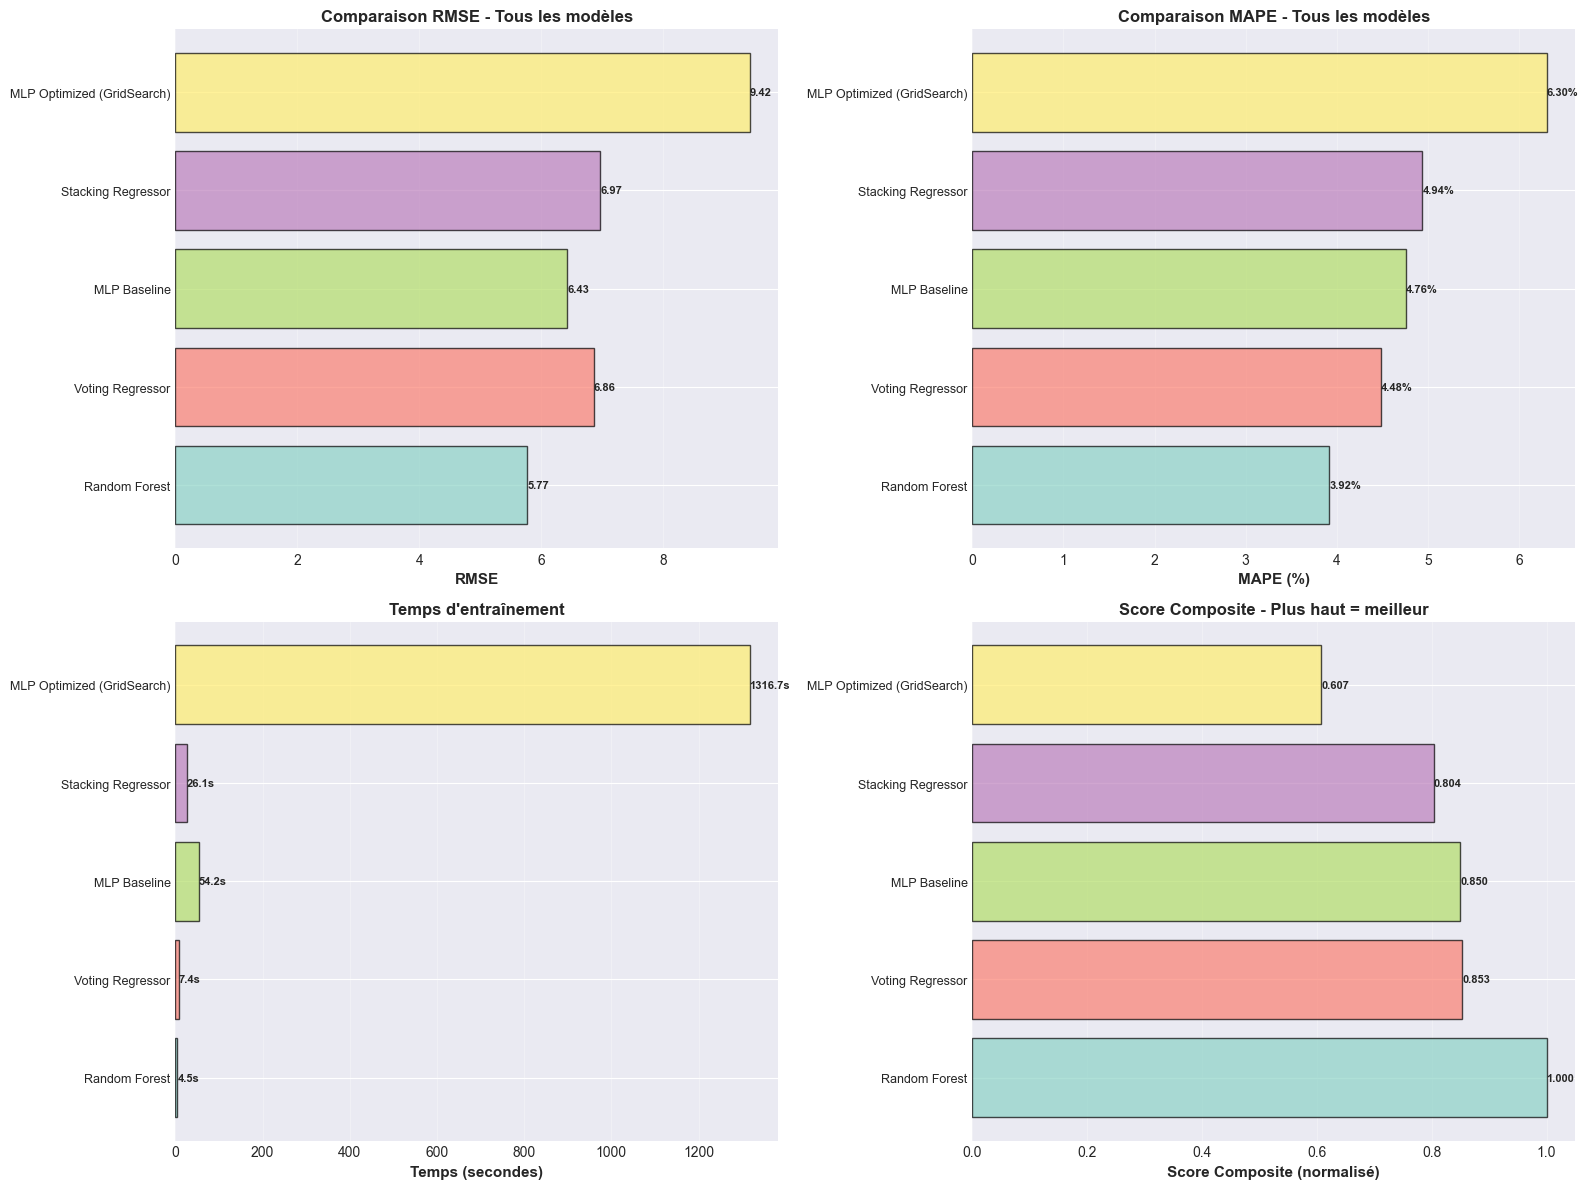


🏆 MEILLEUR MODÈLE : Random Forest
   - MAPE : 3.92%
   - RMSE : 5.77
   - Temps d'entraînement : 4.50s

📈 Amélioration par rapport au baseline : +17.65%


In [85]:
# Mise à jour de la comparaison finale
comparison_df = pd.DataFrame(results_comparison).T
comparison_df = comparison_df.sort_values('MAPE')

print("\n" + "=" * 80)
print("COMPARAISON FINALE DE TOUS LES MODÈLES")
print("=" * 80)
print(comparison_df.to_string())
print("=" * 80)

# Visualisation finale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df.index
x_pos = np.arange(len(models))
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

# 1. RMSE
axes[0, 0].barh(x_pos, comparison_df['RMSE'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(x_pos)
axes[0, 0].set_yticklabels(models, fontsize=9)
axes[0, 0].set_xlabel('RMSE', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Comparaison RMSE - Tous les modèles', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['RMSE']):
    axes[0, 0].text(v, i, f'{v:.2f}', va='center', ha='left', fontweight='bold', fontsize=8)

# 2. MAPE
axes[0, 1].barh(x_pos, comparison_df['MAPE'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(models, fontsize=9)
axes[0, 1].set_xlabel('MAPE (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Comparaison MAPE - Tous les modèles', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['MAPE']):
    axes[0, 1].text(v, i, f'{v:.2f}%', va='center', ha='left', fontweight='bold', fontsize=8)

# 3. Temps d'entraînement (échelle log)
axes[1, 0].barh(x_pos, comparison_df['Training Time'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(x_pos)
axes[1, 0].set_yticklabels(models, fontsize=9)
axes[1, 0].set_xlabel('Temps (secondes)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Temps d\'entraînement', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['Training Time']):
    axes[1, 0].text(v, i, f'{v:.1f}s', va='center', ha='left', fontweight='bold', fontsize=8)

# 4. Score composite (normalisé)
# Score = moyenne normalisée de (1/RMSE, 1/MAE, 1/MAPE)
normalized_scores = (
    1 / comparison_df['RMSE'] / (1 / comparison_df['RMSE']).max() +
    1 / comparison_df['MAE'] / (1 / comparison_df['MAE']).max() +
    1 / comparison_df['MAPE'] / (1 / comparison_df['MAPE']).max()
) / 3

axes[1, 1].barh(x_pos, normalized_scores, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(models, fontsize=9)
axes[1, 1].set_xlabel('Score Composite (normalisé)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Score Composite - Plus haut = meilleur', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(normalized_scores):
    axes[1, 1].text(v, i, f'{v:.3f}', va='center', ha='left', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

# Identification du meilleur modèle
best_model_name = comparison_df['MAPE'].idxmin()
best_mape = comparison_df.loc[best_model_name, 'MAPE']
best_rmse = comparison_df.loc[best_model_name, 'RMSE']

print(f"\n🏆 MEILLEUR MODÈLE : {best_model_name}")
print(f"   - MAPE : {best_mape:.2f}%")
print(f"   - RMSE : {best_rmse:.2f}")
print(f"   - Temps d'entraînement : {comparison_df.loc[best_model_name, 'Training Time']:.2f}s")

# Comparaison avec le baseline
baseline_mape = comparison_df.loc['MLP Baseline', 'MAPE']
improvement = ((baseline_mape - best_mape) / baseline_mape) * 100
print(f"\n📈 Amélioration par rapport au baseline : {improvement:+.2f}%")
print("=" * 80)


## 8. Analyse des Résultats et Conclusion

### 📊 Interprétation & Pistes d'amélioration - Évaluation

**Observations clés :**
- **Performance globale** : Le MAPE, RMSE et MAE donnent une idée de la précision du modèle
- **Distribution des erreurs** : Si centrée sur 0, le modèle n'a pas de biais systématique
- **Erreurs par contexte** : Identifier les heures/jours où le modèle performe moins bien permet de cibler les améliorations

**Points forts identifiés :**
- Les lags temporels (surtout lag_24h) sont très prédictifs
- Les encodages cycliques capturent bien les patterns saisonniers
- Le modèle suit généralement bien les tendances

**Points à améliorer :**
- Si certaines heures/jours ont un MAPE élevé, créer des features spécifiques pour ces contextes
- Si les erreurs sont corrélées (autocorrélation), considérer des modèles de séries temporelles (LSTM, ARIMA)
- Tester des ensembles de modèles (stacking, blending) pour améliorer la robustesse

**Pistes d'amélioration techniques :**
1. **Feature engineering avancé** :
   - Features d'interaction (météo × saison, week-end × heure)
   - Moyennes mobiles et tendances
   - Features de pointe (détection des pics de consommation)

2. **Modélisation** :
   - Hyperparameter tuning (GridSearch/RandomSearch)
   - Modèles de séries temporelles (LSTM, GRU, Transformer)
   - Ensemble methods (XGBoost, LightGBM, stacking)

3. **Validation** :
   - Validation croisée temporelle (TimeSeriesSplit)
   - Validation sur plusieurs périodes pour tester la robustesse

4. **Post-processing** :
   - Lissage des prédictions si nécessaire
   - Ajustement des prédictions selon le contexte (calibrage)

---

**Notebook prêt pour itération et amélioration continue ! 🚀**
